# Machine Learning Applications 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv("database_fin.csv")

## Data Preprocessing

**Delete useless features:**

In [3]:
df.drop(labels=['name', 'markets', 'year', 'artist', 'time_signature'], 
        axis=1, inplace=True)

* **name**: not useful (we already have something for lenght_name): one idea could be to use NLP to analyze song names? 
* **markets**
* **year**: our dataset is distributed over 3 years so this feature will not explain anything. It could be used with a large dataset over time with different weights per year
* **artist**: not useful
* **time_signature**: due to the origin of our dataset, we only have 4/4 songs. We believe that this feature should be useful with a larger dataset

## Converting categorical features into dummy variables

In [4]:
#We want to have more information on whether or not the months have importance
#months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
        # 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 
        # 12:'December'}
#df['month'] = df['month'].map(months)

In [5]:
dummies = ['album_type', 'record_company', 'genres', 'solo_group']

In [6]:
prefix=['album_type', 'company', 'genre', 'group/gender']

dummy_variables = pd.get_dummies(df[dummies], prefix=prefix, drop_first=True)

In [7]:
df.drop(labels=dummies, axis=1, inplace=True)

In [8]:
df = pd.concat([df, dummy_variables], axis=1)

In [9]:
#Now working for nested list values:
df_nested = df[['peak', 'country_code']].copy()

df_nested['peak'] = df_nested['peak'].apply(lambda x: x.replace('[', '').replace(']', '').split(', '))

df_nested['country_code'] = df_nested['country_code'].apply(lambda x: x.split(', '))

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

peak = df_nested['peak']
mlb_peak = MultiLabelBinarizer()
df_peak = pd.DataFrame(mlb_peak.fit_transform(peak),columns=mlb_peak.classes_, 
                       index=df_nested.index)
df_peak.rename(columns={'0':'peak_before', '1':'peak_at', '2':'peak_after'}, inplace=True)

In [11]:
country_code = df_nested['country_code']
mlb_ccode = MultiLabelBinarizer()
df_ccode = pd.DataFrame(mlb_ccode.fit_transform(country_code),columns=mlb_ccode.classes_, 
                       index=df_nested.index)

In [12]:
df.drop(labels=['peak', 'country_code'], axis=1, inplace=True)

In [13]:
df = pd.concat([df, df_peak, df_ccode], axis=1)

## Deleting some features
Some features were extracted, representing the same thing, so we need to keep some of them and delete the others: ``artist_popularity_mean``, ``artist_popularity_max``, ``followers_mean``, ``followers_max``, ``GT_mean_value``, ``GT_std_value``, ``GT_range_value``
* We will choose base on the tests we performed earlier (pearson and spearman)
* Delete: ``artist_popularity_max``, ``followers_max``, ``GT_mean_value``

In [14]:
delete_features = ['artist_popularity_max', 'followers_max', 'GT_mean_value']
df.drop(labels=delete_features, axis=1, inplace=True)

## Dealing with Lyrics
* Step1: converting non-english text in english using googletrans library
* Step2:
 * Removing stop words
 * Lemming and Stemming
 * Vectorizing our lyrics corpus
* Step3:
 * TF-IDF for weighting and normalization
 * We will keep both possibilities (bag-of-words dataset and TF-IDF dataset)
 
NB: the translation is a quick and dirty method, especially using Google Translate, but we are interested in avoiding counting twice two words that have the same meaning. therefore, a "word-by-word" translation is ok. Moreover, Google Translate keep the words in the lyrics that are shouted like: poompoom, ddddy, bababababaila, etc.
However, we need to recall that this is **quick and dirty**

**Step 1:**

In [15]:
from googletrans import Translator
translator = Translator()

def translating(lyrics):
    if translator.detect(lyrics).lang == 'en':
        return lyrics
    else:
        return translator.translate(lyrics, dest='en').text.lower()

In [16]:
df['lyrics'] = df['lyrics'].apply(translating)

**Step 2:**

In [17]:
import nltk
from nltk.corpus import stopwords

In [18]:
#Removing Stopwords
stop_en = stopwords.words('english')

#during the extraction of lyrics, we removed punctuation
import string
stop_en = [''.join(char for char in word if char not in string.punctuation) for word in stop_en]
stop_en.append('im')

df['lyrics'] = df['lyrics'].apply(lambda x: " ".join([words for words in x.split() if words not in stop_en]))

Also we want to focus on words that appear more than once in our dataset because we are more interested in words that could have a positive impact and could determine a popular song pattern. For instance we want to see if joyful words drive popularity. 
*(i.e. what we want to avoid is unique words that made a song highly popular like "Gangnam Style")*

**Without stemming:**

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
count_ws = CountVectorizer(min_df=2).fit(df['lyrics'])

In [21]:
len(count_ws.vocabulary_)

1577

**With stemming:**

In [22]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def stemming(lyrics):
    return ' '.join((stemmer.stem(words) for words in lyrics.split()))

In [23]:
count_s = CountVectorizer(min_df=2).fit(df['lyrics'].apply(stemming))

In [24]:
len(count_s.vocabulary_)

1424

We have a difference of 153 words

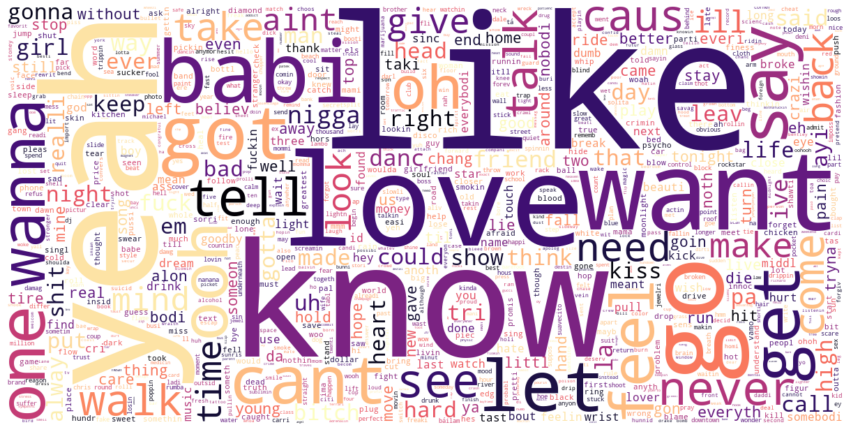

<Figure size 432x288 with 0 Axes>

In [26]:
#Wordcloud
from wordcloud import WordCloud
plt.figure(figsize=(15,8))

freqs = np.array(count_s.transform(df['lyrics'].apply(stemming)).todense()).sum(axis=0)

lyrics_wds = dict(zip(count_s.get_feature_names(), freqs))

wc = WordCloud(background_color='white', colormap="magma", height=600, min_font_size=2, width=1200, 
               max_words=1000).generate_from_frequencies(lyrics_wds)

plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

#plt.savefig("55-wordcloud_lyrics.png", dpi=400)

**Let's go on with stemming:**

In [27]:
df['lyrics'] = df['lyrics'].apply(stemming)

In [28]:
lyrics_bow = CountVectorizer(min_df=2).fit_transform(df['lyrics'])

In [29]:
print('Shape of Sparse Matrix: ', lyrics_bow.shape)
print('Amount of Non-Zero occurences: ', lyrics_bow.nnz)
print('sparsity:', lyrics_bow.nnz/(lyrics_bow.shape[0]*lyrics_bow.shape[1])*100)

Shape of Sparse Matrix:  (144, 1424)
Amount of Non-Zero occurences:  10411
sparsity: 5.0771496566791505


**Step 3:**

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

In [31]:
lyrics_tfidf = TfidfTransformer().fit_transform(lyrics_bow)

## Feature sets

Due to preliminary tests (see results below), we would like to come up with another popularity variable for classification because standard algorithms are unable to perform at least one "hit" prediction with the one previously defined.

In [32]:
df['song_popularity'].describe()

count    144.000000
mean      77.298611
std       16.051090
min       10.000000
25%       77.000000
50%       82.000000
75%       85.000000
max       94.000000
Name: song_popularity, dtype: float64

In [33]:
#We define a threshold based on the 3rd quartile of our dataset
#We use > instead of >= to penalize the songs=85 because our dataset is composed mostly of songs in that area of popularity
df['popu_level'] = df['song_popularity'].apply(lambda x: 1 if x > 85 else 0)

In [34]:
#Popular songs are the top 20%
(df['popu_level'] == 1).sum() / len(df) * 100

20.833333333333336

In [35]:
target_features = ['song_popularity', 'hit/non_hit', 'popu_level']

song_metadata = ['duration_ms', 'explicit_lyrics', 'name_length', 'holiday_effect', 'album_type_single', 'genre_dance',
                 'genre_hip-hop/rap', 'genre_indie', 'genre_latin/reggaeton', 'genre_pop', 'genre_r&b', 'genre_rock', 
                 'genre_soundtrack', 'month', 'company_Independent, Sony', 'company_Independent, Universal', 
                 'company_Independent, Warner', 'company_Sony', 'company_Universal', 'company_Universal, Sony', 
                 'company_Universal, Warner', 'company_Warner']

audio_features = ['key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
                  'loudness', 'speechiness', 'valence', 'tempo']

artist_metadata = ['artist_popularity_mean', 'followers_mean', 'GT_std_value', 'GT_range_value', 'peak_before', 
                   'peak_at', 'peak_after', 'age', 'group/gender_group_male', 'group/gender_group_mixed',
                   'group/gender_solo_female', 'group/gender_solo_male', 'group/gender_solo_other', 'AR', 'AU', 'BR', 
                   'CA', 'CO', 'DE', 'DO', 'ES', 'FR', 'GB', 'IL', 'IT', 'LT', 'MX', 'NL', 'PA', 'PR', 'SE', 'TT', 'US']

lyrics_1 = pd.DataFrame(lyrics_bow.todense())

lyrics_2 = pd.DataFrame(lyrics_tfidf.todense())

X_all_1 = pd.concat([df[song_metadata+audio_features+artist_metadata], lyrics_1], axis=1)
X_all_2 = pd.concat([df[song_metadata+audio_features+artist_metadata], lyrics_2], axis=1)

## PCA Visualization
We use the popularity definitions: **``hit/non_hit``** and **``popu_level``** as hues

Text(0, 0.5, 'Second Principal Component')

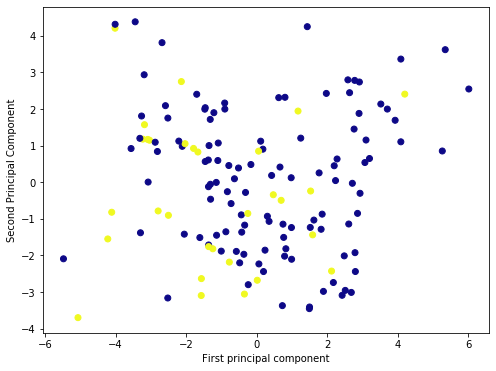

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[song_metadata+audio_features+artist_metadata])
scaled_data = scaler.transform(df[song_metadata+audio_features+artist_metadata])

df_pca = scaled_data #in case we want to try other combination

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['popu_level'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

#plt.savefig("56-PCA_popu_level.png", dpi=400)

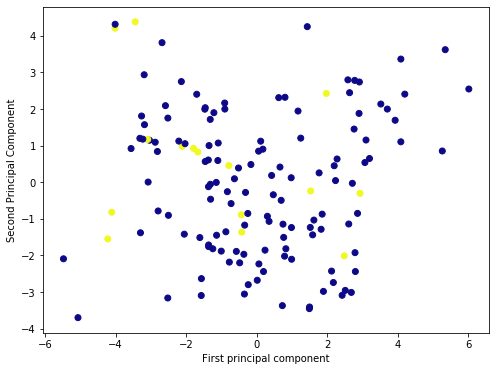

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['hit/non_hit'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

plt.savefig("56-PCA_hit_non_hit.png", dpi=400)

In [38]:
#Coefficient Analysis: Eigen vectors
pca_coeff = pd.DataFrame(pca.components_, columns=df[song_metadata+audio_features+artist_metadata].columns).transpose()
pca_coeff.head()

,0,1
duration_ms,0.092254,0.090145
explicit_lyrics,-0.206231,0.232553
name_length,-0.124860,-0.138622
holiday_effect,-0.043481,0.039456
album_type_single,0.238525,-0.069388


In [39]:
#Main features for component 1:
pca_coeff[0].apply(abs).sort_values(ascending=False).head(15)

loudness                    0.260127
energy                      0.259700
genre_latin/reggaeton       0.254258
album_type_single           0.238525
genre_hip-hop/rap           0.235286
PR                          0.223981
artist_popularity_mean      0.217734
explicit_lyrics             0.206231
valence                     0.193231
group/gender_solo_male      0.191976
peak_before                 0.184920
group/gender_group_mixed    0.182131
age                         0.178985
followers_mean              0.171028
GT_range_value              0.162482
Name: 0, dtype: float64

In [40]:
#Main features for component 2:
pca_coeff[1].apply(abs).sort_values(ascending=False).head(15)

genre_pop                    0.357421
genre_hip-hop/rap            0.269606
danceability                 0.246310
genre_latin/reggaeton        0.238087
PR                           0.237553
explicit_lyrics              0.232553
peak_at                      0.195977
company_Universal, Warner    0.189900
GB                           0.186316
group/gender_solo_female     0.179713
CA                           0.178596
artist_popularity_mean       0.177282
group/gender_group_male      0.159631
group/gender_group_mixed     0.156778
speechiness                  0.146414
Name: 1, dtype: float64

In [41]:
#Variance analysis: Eigen values
print(f"Component 1: {pca.explained_variance_ratio_[0]}\nComponent 2: {pca.explained_variance_ratio_[1]}")

Component 1: 0.08142703393305181
Component 2: 0.056358697088437784


Our features are not correlated enough to explain the variations of our individuals
 // 
Or no variations (low inertia)

In [42]:
sum(pca.explained_variance_ratio_)

0.1377857310214896

**Key Findings:**
* Main features to differentiate our songs are: loudness, energy, genre_latin/reggaeton, album_type_single, genre_hip-hop/rap and genre_pop, danceability, explicit_lyrics
* In both components (significant coefficients), we have: genre_latin/reggaeton, genre_hip-hop/rap, PR, features related to group/gender, explicit_lyrics, peak values
* Latin individuals seems to be different from others (because their associated features are among the top coefficients)
* Main components does not explain variance well (only 12.29% cumulated)

### Smaller sets of features:

**Audio features:**

Text(0, 0.5, 'Second Principal Component')

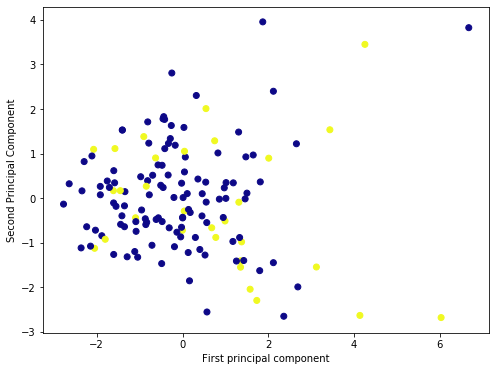

In [43]:
scaler = StandardScaler()
scaler.fit(df[audio_features])
scaled_data = scaler.transform(df[audio_features])

df_pca = scaled_data #in case we want to try other combination

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['popu_level'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

#plt.savefig("56-PCA_audiofeature_popu_level.png", dpi=400)

In [44]:
pca_coeff = pd.DataFrame(pca.components_, columns=df[audio_features].columns).transpose()

In [45]:
#Main features for component 1:
pca_coeff[0].apply(abs).sort_values(ascending=False).head(15)

loudness            0.558827
energy              0.538582
valence             0.398500
acousticness        0.332132
instrumentalness    0.242142
speechiness         0.189250
danceability        0.136346
mode                0.109998
liveness            0.039461
tempo               0.031571
key                 0.028917
Name: 0, dtype: float64

In [46]:
#Main features for component 2:
pca_coeff[1].apply(abs).sort_values(ascending=False).head(15)

speechiness         0.582856
danceability        0.533747
liveness            0.285628
instrumentalness    0.280978
tempo               0.261572
acousticness        0.211130
valence             0.200196
mode                0.191545
loudness            0.110796
key                 0.107498
energy              0.035559
Name: 1, dtype: float64

In [47]:
#Variance analysis: Eigen values
print(f"Component 1: {pca.explained_variance_ratio_[0]}\nComponent 2: {pca.explained_variance_ratio_[1]}")

sum(pca.explained_variance_ratio_)

Component 1: 0.22402349476368033
Component 2: 0.135121471293162


0.3591449660568423

**Artist Metadata:**

Text(0, 0.5, 'Second Principal Component')

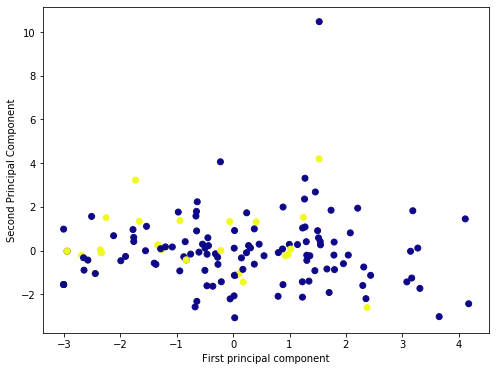

In [48]:
scaler = StandardScaler()
scaler.fit(df[artist_metadata])
scaled_data = scaler.transform(df[artist_metadata])

df_pca = scaled_data #in case we want to try other combination

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['popu_level'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

#plt.savefig("56-PCA_artistmeta_popu_level.png", dpi=400)

In [49]:
pca_coeff = pd.DataFrame(pca.components_, columns=df[artist_metadata].columns).transpose()

In [50]:
#Main features for component 1:
pca_coeff[0].apply(abs).sort_values(ascending=False).head(15)

peak_before                 0.330404
group/gender_solo_male      0.326413
group/gender_group_mixed    0.318344
artist_popularity_mean      0.313830
age                         0.276036
GT_range_value              0.273411
followers_mean              0.265127
PR                          0.211806
peak_at                     0.204794
GT_std_value                0.202723
group/gender_solo_female    0.181787
peak_after                  0.177929
CO                          0.172428
FR                          0.157906
group/gender_group_male     0.149134
Name: 0, dtype: float64

In [51]:
#Main features for component 2:
pca_coeff[1].apply(abs).sort_values(ascending=False).head(15)

artist_popularity_mean    0.389431
GT_std_value              0.375973
GT_range_value            0.372789
LT                        0.349182
IT                        0.347091
followers_mean            0.325447
peak_at                   0.248394
PR                        0.203920
peak_after                0.135525
IL                        0.135370
FR                        0.114305
CA                        0.112281
SE                        0.086704
US                        0.079458
CO                        0.078898
Name: 1, dtype: float64

In [52]:
#Variance analysis: Eigen values
print(f"Component 1: {pca.explained_variance_ratio_[0]}\nComponent 2: {pca.explained_variance_ratio_[1]}")

sum(pca.explained_variance_ratio_)

Component 1: 0.0905207856906348
Component 2: 0.07601259987194592


0.16653338556258074

**Song Metadata:**

Text(0, 0.5, 'Second Principal Component')

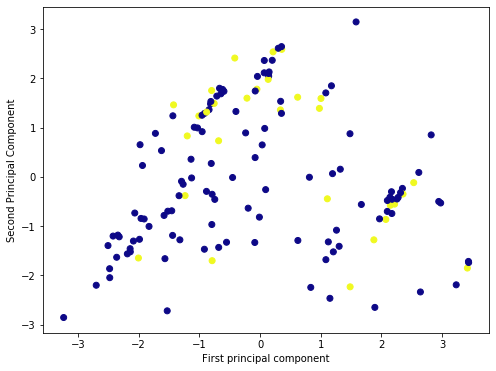

In [53]:
scaler = StandardScaler()
scaler.fit(df[song_metadata])
scaled_data = scaler.transform(df[song_metadata])

df_pca = scaled_data #in case we want to try other combination

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['popu_level'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

#plt.savefig("56-PCA_songmeta_popu_level.png", dpi=400)

In [54]:
pca_coeff = pd.DataFrame(pca.components_, columns=df[song_metadata].columns).transpose()

In [55]:
#Main features for component 1:
pca_coeff[0].apply(abs).sort_values(ascending=False).head(15)

genre_hip-hop/rap                 0.492971
explicit_lyrics                   0.471126
album_type_single                 0.381044
genre_latin/reggaeton             0.285118
company_Warner                    0.227137
company_Universal, Warner         0.223999
company_Sony                      0.220227
company_Universal                 0.182744
company_Independent, Warner       0.132920
duration_ms                       0.129378
genre_dance                       0.128636
genre_r&b                         0.116450
company_Independent, Universal    0.108392
company_Universal, Sony           0.106088
genre_pop                         0.104429
Name: 0, dtype: float64

In [56]:
#Main features for component 2:
pca_coeff[1].apply(abs).sort_values(ascending=False).head(15)

genre_pop                         0.573695
company_Universal                 0.357083
name_length                       0.289941
genre_hip-hop/rap                 0.287135
genre_latin/reggaeton             0.265692
explicit_lyrics                   0.229087
company_Sony                      0.191227
album_type_single                 0.181741
duration_ms                       0.181314
company_Independent, Universal    0.179111
company_Universal, Warner         0.156636
company_Independent, Sony         0.132220
company_Universal, Sony           0.118045
genre_r&b                         0.116082
holiday_effect                    0.114370
Name: 1, dtype: float64

In [57]:
#Variance analysis: Eigen values
print(f"Component 1: {pca.explained_variance_ratio_[0]}\nComponent 2: {pca.explained_variance_ratio_[1]}")

sum(pca.explained_variance_ratio_)

Component 1: 0.11593119485133606
Component 2: 0.0918820027799942


0.20781319763133027

Given the last 3 graphics, it seems that audio features and song_metadata are better than artist_metadata to explain the variations among our individuals 

**Try a PCR ?**

In [59]:

scaler_all = StandardScaler()
scaler_all.fit(df[song_metadata+artist_metadata+audio_features])
scaled_data_all = scaler_all.transform(df[song_metadata+artist_metadata+audio_features])

scaler_sparse = StandardScaler(with_mean=False)
scaler_sparse.fit(lyrics_2)
scaled_data_sparse = scaler_sparse.transform(lyrics_2)

columns_1 = df[song_metadata+artist_metadata+audio_features].columns 
columns_2 = lyrics_2.columns

df_pca = pd.concat([pd.DataFrame(scaled_data_all, columns=columns_1), 
                    pd.DataFrame(scaled_data_sparse, columns=columns_2)], axis=1)

from sklearn.decomposition import PCA
pca = PCA(n_components=110)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

In [60]:
sum(pca.explained_variance_ratio_)

0.9041059263222955

* Try this another time

# Machine Learning
**Methodology:**

**Step 1:**
For each definition of song popularity: 

We train several models for different tasks: 
* Linear Regression
* Logistic Regression
* K-Nearest Neighbors
* Random Forest
* Support Vector Machines with a Linear and Gaussian kernel
* Multilayer Perceptron for classification task

We perform feature selection using the following methods:
* Backward Elimination and Forward Selection with Linear Regression (based on adjusted R2)
* Lasso Regularization for Linear Regression, Logistic Regression and SVM
* SelectFromModel with Random Forest

Performance:
* Metrics: R2, R2 adjusted, RMSE, F1-score (precision / recall)
* Identify Overfitting / Underfitting

**Step2 Perform optimization using Cross-Validation:**
* Train-Validation-Test-Split when feasible
* Using Stratified K-Fold cross validation to tune hyperparameters
* Overfitting/Underfitting: Regularization
* Hyperparameter tunning using GridSearchCV

## Linear Regression
* Distribution of song popularity
* Multicolinearity
* Train/Test split
* Feature scaling
* Quick and Dirty Linear Regressions
* Feature selection: Step forward and Step backward / Lasso regression / Ridge regression
* Variance / bias analysis
* Addition of lyrics into the model

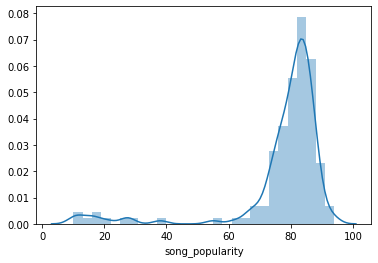

In [61]:
#Popularity distribution
sns.distplot(df[df['song_popularity']>0]['song_popularity'])

**Multicolinearity:** High correlations between some of our independent features
* artist_popularity_mean / followers_mean (0.65)
* GT_range_value / GT_std_value (0.53)
* energy / acousticness (-0.43)
* energy / valence (0.41)
* energy / loudness (0.76)
* valence / loudness (0.4)

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

import statsmodels.api as sm

In [63]:
#Train and Test split for use later on (if we manage to get a result on the training set)
#We keep the ability to test different thresholds to exclude outliers

X = df[df['song_popularity']>=0][song_metadata+artist_metadata+audio_features]
y = df[df['song_popularity']>=0][target_features[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [64]:
#Testing a threshold at 40 to remove outliers (given our ditribution)
X_th = df[df['song_popularity']>=40][song_metadata+artist_metadata+audio_features]
y_th = df[df['song_popularity']>=40][target_features[0]]

X_train_th, X_test_th, y_train_th, y_test_th = train_test_split(X_th, y_th, test_size=0.2, random_state=10)

In [65]:
#Scaling 1
scaler = StandardScaler()

scaled_data = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X.columns)

scaled_test_data = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [66]:
#Scaling 2
scaler_th = StandardScaler()

scaled_data_th = pd.DataFrame(data=scaler_th.fit_transform(X_train_th), columns=X_th.columns)

scaled_test_data_th = pd.DataFrame(data=scaler_th.transform(X_test_th), columns=X_th.columns)

### Song Metadata

In [67]:
# 0 threshold
features = song_metadata

scaled_data_intercept = sm.add_constant(scaled_data[features].values)

xname = ['const'] + list(scaled_data[features].columns)

lm = sm.OLS(y_train, scaled_data_intercept)

lm_results = lm.fit()

print(lm_results.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.130
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.332
Time:                        00:27:08   Log-Likelihood:                -459.53
No. Observations:                 115   AIC:                             965.1
Df Residuals:                      92   BIC:                             1028.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

* Fisher Test ==> do not reject H0, non-significant
* Several unexpected coefficients: genre_hip-hop/rap, genre_pop, company_Universal, company_Universal, Warner, that should be positive
* Non-significant p-values, except for: genre_r&b, company_Sony, company_Universal (around 5%-10%, which is not bad given the size of our dataset)

In [68]:
# 40 threshold
features = song_metadata

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.407
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.135
Time:                        00:27:27   Log-Likelihood:                -326.11
No. Observations:                 108   AIC:                             698.2
Df Residuals:                      85   BIC:                             759.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

* Fisher Test ==> do not reject H0, non-significant, but improvement in the p-value (from 0.33 to 0.13)
* Still several unexpected coefficients: all genres have negative coefficients ==> meaning that country (our last one) would be the "popular" genre. This is strange when comparing to reality.
* Non-significant p-values, except for: genre_latin/reggaeton, genre_r&b, genre_soundtrack and company_Warner (around 5%-10%, which is not bad given the size of our dataset)

### Artist Metadata

In [69]:
# 0 threshold
features = artist_metadata

scaled_data_intercept = sm.add_constant(scaled_data[features].values)

xname = ['const'] + list(scaled_data[features].columns)

lm = sm.OLS(y_train, scaled_data_intercept)

lm_results = lm.fit()

print(lm_results.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                 -0.098
Method:                 Least Squares   F-statistic:                    0.6496
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.905
Time:                        00:27:53   Log-Likelihood:                -461.77
No. Observations:                 115   AIC:                             983.5
Df Residuals:                      85   BIC:                             1066.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


* Fisher Test ==> do not reject H0, non-significant but low p-value
* Several unexpected coefficients: like artist_popularity_mean that should be positive
* Non-significant p-values, except for: followers_mean, MX (around 5%-10%, which is not bad given the size of our dataset)

In [70]:
# 40 threshold
features = artist_metadata

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     1.514
Date:                Thu, 28 May 2020   Prob (F-statistic):             0.0781
Time:                        00:28:02   Log-Likelihood:                -319.68
No. Observations:                 108   AIC:                             697.4
Df Residuals:                      79   BIC:                             775.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

* Fisher Test ==> do not reject H0, non-significant but low and better p-value
* Several unexpected coefficients: artist_popularity_mean became positive but all three features peak before, at, after are negative (multicolinearity)
* Non-significant p-values, except for: artist_popularity_mean, ES, FR (around 5%-10%, which is not bad given the size of our dataset)

In [72]:
#Removing features that are correlated: keeping artist_popularity_mean and GT_std_value
# 40 threshold
features = set(artist_metadata) - set(['followers_mean', 'GT_range_value'])

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1.553
Date:                Thu, 28 May 2020   Prob (F-statistic):             0.0698
Time:                        00:28:14   Log-Likelihood:                -321.04
No. Observations:                 108   AIC:                             696.1
Df Residuals:                      81   BIC:                             768.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

* Similar Results (both on Fisher Propability and R2 adjusted)

### Audio Features

In [73]:
# 0 threshold
features = audio_features

scaled_data_intercept = sm.add_constant(scaled_data[features].values)

xname = ['const'] + list(scaled_data[features].columns)

lm = sm.OLS(y_train, scaled_data_intercept)

lm_results = lm.fit()

print(lm_results.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     2.216
Date:                Thu, 28 May 2020   Prob (F-statistic):             0.0188
Time:                        00:29:21   Log-Likelihood:                -461.07
No. Observations:                 115   AIC:                             946.1
Df Residuals:                     103   BIC:                             979.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               77.9478      1.314  

* Fisher Test ==> reject H0, significant
* Non-significant p-values, except for: liveness

In [74]:
# 40 threshold
features = audio_features

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.661
Date:                Thu, 28 May 2020   Prob (F-statistic):             0.0942
Time:                        00:29:27   Log-Likelihood:                -333.47
No. Observations:                 108   AIC:                             690.9
Df Residuals:                      96   BIC:                             723.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               81.1111      0.541  

* Worst results for the fisher test
* Non-significant p-values, except for: acousticness, energy, loudness

In [75]:
#Removing features that are correlated: keeping energy
#Remove: acousticness, loudness and valence
# 40 threshold
features = set(audio_features) - set(['acousticness', 'loudness', 'valence'])

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.299
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.253
Time:                        00:29:34   Log-Likelihood:                -337.49
No. Observations:                 108   AIC:                             693.0
Df Residuals:                      99   BIC:                             717.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               81.1111      0.553  

* Poorer results but energy becomes significant

In [76]:
#Removing features that are correlated: keeping energy, acousticness and valence
#Remove: loudness
# 40 threshold
features = set(audio_features) - set(['loudness'])

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.399
Date:                Thu, 28 May 2020   Prob (F-statistic):              0.192
Time:                        00:29:39   Log-Likelihood:                -335.60
No. Observations:                 108   AIC:                             693.2
Df Residuals:                      97   BIC:                             722.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               81.1111      0.549  

### Feature Selection:
* LassoCV on the whole dataset: no threshold / with threshold
* Forward and Backward selection process based on r2 adjusted
* RidgeCV using the features selected through the previous methods

NB: Forward and Backward methods will probably lead to overfitting our training set.

**Lasso Regularization with Cross Validation: no threshold**

LassoCV uses r2 score to optimize the regularization parameter alpha on the cross validation set

In [78]:
from sklearn.model_selection import KFold

In [80]:
alphas = np.arange(0.01,20,0.02)

lasso = LassoCV(alphas=alphas, cv=KFold(n_splits=5,shuffle=True), max_iter=2000).fit(scaled_data,y_train)

pred = lasso.predict(scaled_test_data)

print(f"Selected alpha using Cross Validation on Train set: {lasso.alpha_}")
print(f"RMSE with Lasso Regularization: {np.sqrt(metrics.mean_squared_error(y_test,pred))}")

coeff_lasso = pd.DataFrame(data=lasso.coef_,index=scaled_data.columns,columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {lasso.intercept_}")
coeff_lasso[coeff_lasso['Coeff']!=0]

Selected alpha using Cross Validation on Train set: 2.4099999999999993
RMSE with Lasso Regularization: 20.391781501836387
intercept term: 77.94782608695652


,Coeff
liveness,-2.648642
MX,-1.271595
genre_r&b,-0.298466
energy,-0.154497


* We might have non-linear relationship that are not captured by our model and therefore, coefficients are set to 0
* We tried to run the code several time, even with values of alpha between 0 and 50: the alphas appears to be randomly selected, based on the the KFold performed ==> some outliers might prevent from learning a "good" hypothesis ==> but the RMSE on test set cannot go down 20
* Overall, ``liveness``, ``MX``, ``genre_r&b`` and ``energy`` seem to be interesting features
* Only negative coefficients

**Lasso Regularization with Cross Validation: threshold to remove outliers**

In [82]:
alphas = np.arange(0.01,50,0.02)

lasso = LassoCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True), max_iter=2000).fit(scaled_data_th,y_train_th)

pred = lasso.predict(scaled_test_data_th)
pred_train = lasso.predict(scaled_data_th)

print(f"Selected alpha using Cross Validation on Train set: {lasso.alpha_}")
print(f"RMSE with Lasso Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Lasso Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_lasso = pd.DataFrame(data=lasso.coef_,index=scaled_data_th.columns,columns=['Coeff']).sort_values(by='Coeff')

indexes=coeff_lasso[coeff_lasso['Coeff']!=0].index

print(f"intercept term: {lasso.intercept_}")
coeff_lasso[coeff_lasso['Coeff']!=0]

Selected alpha using Cross Validation on Train set: 0.44999999999999996
RMSE with Lasso Regularization - Train set: 4.567384676784209
RMSE with Lasso Regularization - Test set: 5.7792494851148355
R2 score - Train set: 0.3773982219441493
R2 score - Test set: 0.20523569520939855
intercept term: 81.11111111111111


,Coeff
AU,-0.839523
genre_latin/reggaeton,-0.815344
company_Warner,-0.752142
FR,-0.724499
genre_soundtrack,-0.424860
energy,-0.416219
BR,-0.241323
group/gender_solo_female,-0.138173
genre_r&b,-0.038157
genre_rock,0.010168


* Undersampling gives us better results
* The selected features using Lasso are: **AU, genre_latin/reggaeton, company_Warner, FR, energy, genre_soundtrack, BR, group/gender_solo_female, holiday_effect, genre_r&b, genre_rock, GT_range_value, group/gender_solo_male, artist_popularity_mean, company_Universal, acousticness**
* Remember that this is for songs between 40 and 100 (94) in song_popularity on a very small dataset

In [83]:
#Testing those selected features with no regularization
features = list(indexes)

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     4.368
Date:                Thu, 28 May 2020   Prob (F-statistic):           1.95e-06
Time:                        00:35:39   Log-Likelihood:                -310.39
No. Observations:                 108   AIC:                             656.8
Df Residuals:                      90   BIC:                             705.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

* We are using the features selected by Lasso
* Best results so far on a training set (good balance between R2 and Adjusted R2)

In [84]:
ols_pred = lm_results_th.predict(np.concatenate((np.ones((27,1)), scaled_test_data_th[features]), axis=1))
print(f"R2 Test Test: {metrics.r2_score(y_test_th, ols_pred)}")
print(f"RMSE Test Test: {np.sqrt(metrics.mean_squared_error(y_test_th, ols_pred))}")

R2 Test Test: 0.11674198982410033
RMSE Test Test: 6.092507305465068


* As expected, the model using only the features selected by Lasso but without applying a penalization results in overfitting the training set

**Comparing using Ridge Regularization:** useful when we have many features, each of them providing a piece of information

In [85]:
alphas = np.arange(10,60,0.02)

ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True)).fit(scaled_data_th,y_train_th)

pred = ridge.predict(scaled_test_data_th)
pred_train = ridge.predict(scaled_data_th)

print(f"Selected alpha using Cross Validation on Train set: {ridge.alpha_}")
print(f"RMSE with Ridge Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Ridge Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_ridge = pd.DataFrame(data=ridge.coef_, index=scaled_data_th.columns, columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {ridge.intercept_}")

coeff_ridge

Selected alpha using Cross Validation on Train set: 59.97999999999894
RMSE with Ridge Regularization - Train set: 4.147447087301335
RMSE with Ridge Regularization - Test set: 5.819292954627396
R2 score - Train set: 0.4866224374726933
R2 score - Test set: 0.19418395715809067
intercept term: 81.11111111111111


,Coeff
AU,-0.760346
company_Warner,-0.735633
FR,-0.730323
energy,-0.676822
group/gender_solo_female,-0.599822
...,...
loudness,0.394485
GT_range_value,0.483685
artist_popularity_mean,0.510582
company_Universal,0.600474


Similar results than with Lasso - overfitting a bit more the training set

In [86]:
#Testing Ridge with the parameters selected by Lasso
features = list(indexes)

alphas = np.arange(10,60,0.02)

ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True)).fit(scaled_data_th[features],y_train_th)

pred = ridge.predict(scaled_test_data_th[features])
pred_train = ridge.predict(scaled_data_th[features])

print(f"Selected alpha using Cross Validation on Train set: {ridge.alpha_}")
print(f"RMSE with Ridge Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Ridge Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_ridge = pd.DataFrame(data=ridge.coef_, index=scaled_data_th[features].columns, columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {ridge.intercept_}")

coeff_ridge

Selected alpha using Cross Validation on Train set: 59.97999999999894
RMSE with Ridge Regularization - Train set: 4.421785297880014
RMSE with Ridge Regularization - Test set: 5.878056617917435
R2 score - Train set: 0.4164602052821019
R2 score - Test set: 0.17782740367835503
intercept term: 81.11111111111111


,Coeff
AU,-0.815991
genre_latin/reggaeton,-0.735885
FR,-0.725303
company_Warner,-0.697828
energy,-0.534984
genre_soundtrack,-0.525384
group/gender_solo_female,-0.432140
BR,-0.431971
genre_r&b,-0.256705
GT_std_value,0.289334


* Better results with Lasso regularization

**Forward Selection and Backward Elimination based on R2 adjusted:**
* Use Both Forward and Backward selection
* Still working with the subsample method that gave us better results
* Linear regression using the selected features and applying a regularization parameter because both selection methods will lead us to overfit the training set
* Comparison with the results of the Lasso Regularization

In [87]:
def forward_selection_r(X, y):
    initial_features = X.columns.tolist()
    best_features = []
    r2_comp=0
    while True:
        remaining_features = list(set(initial_features) - set(best_features))
        r2_adj = dict()
        
        for col in remaining_features:
            model = sm.OLS(y.values, sm.add_constant(X[best_features+[col]])).fit()
            r2_adj[col] = model.rsquared_adj
        max_r2_adj = max(r2_adj, key=lambda k: r2_adj[k])
        
        if(r2_adj[max_r2_adj] >= r2_comp):
            best_features.append(max_r2_adj)
            r2_comp = r2_adj[max_r2_adj]
        else:
            break
    return best_features

In [88]:
def backwad_elimination_r(X, y):
    initial_features = X.columns.tolist()
    r2_comp = sm.OLS(y.values, sm.add_constant(X)).fit().rsquared_adj
    
    while True:   
        r2_adj = dict()        
        for col in initial_features:
            feature_test = list(set(initial_features) - set([col]))
            model = sm.OLS(y.values, sm.add_constant(X[feature_test])).fit()
            r2_adj[col] = model.rsquared_adj
            
        max_r2_adj = max(r2_adj, key=lambda k: r2_adj[k])
        
        if(r2_adj[max_r2_adj] >= r2_comp):
            initial_features.remove(max_r2_adj)
            r2_comp = r2_adj[max_r2_adj]
        else:
            break
    return initial_features

In [90]:
selected_frw = forward_selection_r(scaled_data_th, y_train_th)
selected_frw

['company_Warner',
 'energy',
 'AU',
 'genre_latin/reggaeton',
 'acousticness',
 'loudness',
 'FR',
 'PR',
 'genre_soundtrack',
 'genre_r&b',
 'group/gender_solo_female',
 'genre_hip-hop/rap',
 'peak_after',
 'genre_dance',
 'GT_range_value',
 'ES',
 'artist_popularity_mean',
 'CA',
 'LT',
 'company_Universal',
 'holiday_effect',
 'company_Universal, Warner',
 'liveness',
 'instrumentalness',
 'IT']

In [91]:
features = selected_frw

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     4.774
Date:                Thu, 28 May 2020   Prob (F-statistic):           4.84e-08
Time:                        00:49:45   Log-Likelihood:                -296.04
No. Observations:                 108   AIC:                             642.1
Df Residuals:                      83   BIC:                             709.1
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [92]:
ols_pred = lm_results_th.predict(np.concatenate((np.ones((27,1)), scaled_test_data_th[features]), axis=1))
print(f"R2 Test Test: {metrics.r2_score(y_test_th, ols_pred)}")
print(f"RMSE Test Test: {np.sqrt(metrics.mean_squared_error(y_test_th, ols_pred))}")

R2 Test Test: 0.07288758658007666
RMSE Test Test: 6.241923824284118


In [94]:
selected_bkw = backwad_elimination_r(scaled_data_th, y_train_th)
selected_bkw

['explicit_lyrics',
 'album_type_single',
 'genre_hip-hop/rap',
 'genre_latin/reggaeton',
 'genre_r&b',
 'genre_soundtrack',
 'company_Independent, Sony',
 'company_Universal',
 'company_Universal, Sony',
 'company_Universal, Warner',
 'company_Warner',
 'peak_after',
 'age',
 'group/gender_solo_female',
 'group/gender_solo_other',
 'AR',
 'AU',
 'CA',
 'FR',
 'GB',
 'IT',
 'LT',
 'NL',
 'PR',
 'SE',
 'TT',
 'US',
 'key',
 'mode',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'valence',
 'tempo']

In [95]:
features = selected_bkw

scaled_data_intercept_th = sm.add_constant(scaled_data_th[features].values)

xname = ['const'] + list(scaled_data_th[features].columns)

lm_th = sm.OLS(y_train_th, scaled_data_intercept_th)

lm_results_th = lm_th.fit()

print(lm_results_th.summary(xname=xname))

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3.578
Date:                Thu, 28 May 2020   Prob (F-statistic):           2.96e-06
Time:                        00:53:37   Log-Likelihood:                -292.83
No. Observations:                 108   AIC:                             651.7
Df Residuals:                      75   BIC:                             740.2
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [96]:
ols_pred = lm_results_th.predict(np.concatenate((np.ones((27,1)), scaled_test_data_th[features]), axis=1))
print(f"R2 Test Test: {metrics.r2_score(y_test_th, ols_pred)}")
print(f"RMSE Test Test: {np.sqrt(metrics.mean_squared_error(y_test_th, ols_pred))}")

R2 Test Test: -0.017639659900796856
RMSE Test Test: 6.539571287249357


* Overfitting the training set in both cases
* We prefer the results using forward selection: better trade-off between r2 and r2 adjusted + better p-value for the Fisher test

**Using Ridge Regularization with both sets of selected features:**

In [98]:
#Forward Selection
features = selected_frw

alphas = np.arange(0.01,60,0.02)

ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=5,shuffle=True)).fit(scaled_data_th[features],y_train_th)

pred = ridge.predict(scaled_test_data_th[features])
pred_train = ridge.predict(scaled_data_th[features])

print(f"Selected alpha using Cross Validation on Train set: {ridge.alpha_}")
print(f"RMSE with Ridge Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Ridge Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_ridge = pd.DataFrame(data=ridge.coef_, index=scaled_data_th[features].columns, columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {ridge.intercept_}")

coeff_ridge

Selected alpha using Cross Validation on Train set: 17.47
RMSE with Ridge Regularization - Train set: 3.9697213419463613
RMSE with Ridge Regularization - Test set: 5.77058685976335
R2 score - Train set: 0.5296780802693227
R2 score - Test set: 0.20761648378614916
intercept term: 81.11111111111111


,Coeff
genre_latin/reggaeton,-1.703054
energy,-1.617092
group/gender_solo_female,-1.152176
FR,-1.002531
AU,-0.998532
company_Warner,-0.803336
genre_soundtrack,-0.799175
CA,-0.558707
peak_after,-0.546483
genre_r&b,-0.500960


In [99]:
features = selected_bkw

alphas = np.arange(0.01,60,0.02)

ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True)).fit(scaled_data_th[features],y_train_th)

pred = ridge.predict(scaled_test_data_th[features])
pred_train = ridge.predict(scaled_data_th[features])

print(f"Selected alpha using Cross Validation on Train set: {ridge.alpha_}")
print(f"RMSE with Ridge Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Ridge Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_ridge = pd.DataFrame(data=ridge.coef_, index=scaled_data_th[features].columns, columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {ridge.intercept_}")

coeff_ridge

Selected alpha using Cross Validation on Train set: 8.809999999999999
RMSE with Ridge Regularization - Train set: 3.8383463901963304
RMSE with Ridge Regularization - Test set: 5.883022962668822
R2 score - Train set: 0.5602928725490828
R2 score - Test set: 0.17643751659154527
intercept term: 81.11111111111111


,Coeff
genre_latin/reggaeton,-2.530317
energy,-2.416378
FR,-1.480409
group/gender_solo_female,-1.415400
AU,-1.144634
genre_soundtrack,-1.076809
company_Warner,-1.055434
genre_r&b,-0.909317
CA,-0.840489
tempo,-0.792754


* Forward selected features + Ridge ==> similar performance than LassoCV, maybe a better tuning of alpha could yield better results
* Backward selected features + Ridge ==> LassoCV performed better
* Keep the model with less features ? 

### Using Lyrics
* Quick and Dirty model
* Use all words with a TF-IDF transformation method (lyrics_2) + L2 regularization
* Select among the 100-st words, some vocabulary and use the count (lyrics_1)

In [100]:
vocabulary = count_s.vocabulary_
column_names = [key for number in lyrics_2.columns for key,value in vocabulary.items() if value==number]
lyrics_2.columns = column_names
lyrics_1.columns = column_names

In [101]:
idx_tr = X_train_th.index
idx_te = X_test_th.index

X_train_th_lyr_2 = lyrics_2.iloc[idx_tr]
X_test_th_lyr_2 = lyrics_2.iloc[idx_te]

In [102]:
testing_lyr = LinearRegression()
testing_lyr.fit(X_train_th_lyr_2, y_train_th)
pred_lyr = testing_lyr.predict(X_test_th_lyr_2)
pred_lyr_train = testing_lyr.predict(X_train_th_lyr_2)

print(f"RMSE - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_lyr_train))}")
print(f"RMSE - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred_lyr))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_lyr_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred_lyr)}")

RMSE - Train set: 1.5485919901226005e-14
RMSE - Test set: 7.753784169610583
R2 score - Train set: 1.0
R2 score - Test set: -0.4306153598299638


In [103]:
#Ridge Regularization
alphas = np.arange(0.01,60,0.02)

ridge = RidgeCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True)).fit(X_train_th_lyr_2, y_train_th)

pred = ridge.predict(X_test_th_lyr_2)
pred_train = ridge.predict(X_train_th_lyr_2)

print(f"Selected alpha using Cross Validation on Train set: {ridge.alpha_}")
print(f"RMSE with Ridge Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th, pred_train))}")
print(f"RMSE with Ridge Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th, pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_ridge = pd.DataFrame(data=ridge.coef_, index=X_train_th_lyr_2.columns, columns=['Coeff']).sort_values(by='Coeff')

print(f"intercept term: {ridge.intercept_}")

coeff_ridge

Selected alpha using Cross Validation on Train set: 59.98999999999999
RMSE with Ridge Regularization - Train set: 5.697141708568985
RMSE with Ridge Regularization - Test set: 6.490190444120722
R2 score - Train set: 0.031300178537647994
R2 score - Test set: -0.002329122231912395
intercept term: 81.08629509832373


,Coeff
count,-0.188671
rule,-0.163490
figur,-0.140320
tell,-0.119580
gotta,-0.116178
...,...
kinda,0.094242
somebodi,0.100065
let,0.112941
like,0.128803


In [106]:
#Lasso Regularization
alphas = np.arange(0.01,60,0.02)

lasso = LassoCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True), max_iter=3000).fit(X_train_th_lyr_2, y_train_th)

pred = lasso.predict(X_test_th_lyr_2)
pred_train = lasso.predict(X_train_th_lyr_2)

print(f"Selected alpha using Cross Validation on Train set: {lasso.alpha_}")
print(f"RMSE with Lasso Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Lasso Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_lasso = pd.DataFrame(data=lasso.coef_,index=X_train_th_lyr_2.columns, columns=['Coeff']).sort_values(by='Coeff')

indexes=coeff_lasso[coeff_lasso['Coeff']!=0].index

print(f"intercept term: {lasso.intercept_}")
coeff_lasso[coeff_lasso['Coeff']!=0]

Selected alpha using Cross Validation on Train set: 59.98999999999999
RMSE with Lasso Regularization - Train set: 5.788451678947158
RMSE with Lasso Regularization - Test set: 6.482645398139921
R2 score - Train set: 0.0
R2 score - Test set: 0.0
intercept term: 81.11111111111111


,Coeff


* We probably do not have enough examples in our training set to use the whole lyrics vocabulary
* Both models suffer from very high bias

**Selecting words:**

In [107]:
pd.DataFrame.from_dict(lyrics_wds, orient='index').sort_values(by=0, ascending=False).iloc[0:100].index

Index(['like', 'know', 'yeah', 'love', 'want', 'go', 'babi', 'got', 'let',
       'say', 'cant', 'get', 'ooh', 'one', 'wanna', 'feel', 'oh', 'tell',
       'never', 'see', 'talk', 'caus', 'come', 'walk', 'need', 'take', 'back',
       'give', 'make', 'time', 'look', 'mind', 'aint', 'ill', 'nigga', 'la',
       'way', 'ive', 'friend', 'danc', 'said', 'call', 'girl', 'could', 'hard',
       'right', 'keep', 'night', 'made', 'life', 'think', 'gonna', 'put',
       'heart', 'that', 'pa', 'leav', 'fuck', 'uh', 'day', 'shit', 'bitch',
       'realli', 'bad', 'gotta', 'alway', 'em', 'show', 'ever', 'high', 'man',
       'head', 'ayi', 'kiss', 'tri', 'young', 'everyth', 'left', 'bodi',
       'good', 'away', 'well', 'stop', 'thing', 'better', 'move', 'hit', 'lie',
       'without', 'gon', 'tonight', 'da', 'run', 'taki', 'even', 'still',
       'fall', 'chang', 'littl', 'ride'],
      dtype='object')

In [108]:
#Positive and Negative feelings and some "funny" words
selected_words = ['like', 'know', 'love', 'want', 'wanna', 'babi', 'cant', 'feel', 'never', 'need', 'give', 'nigga',
                  'friend', 'girl', 'man', 'hard', 'life', 'heart', 'fuck', 'shit', 'bitch', 'bad', 'kiss', 'good', 
                  'better', 'lie']

In [109]:
#Use the count of these words
X_train_th_lyr_1 = lyrics_1[selected_words].iloc[idx_tr]
X_test_th_lyr_1 = lyrics_1[selected_words].iloc[idx_te]

testing_lyr = LinearRegression(normalize=True)

testing_lyr.fit(X_train_th_lyr_1, y_train_th)
pred_lyr = testing_lyr.predict(X_test_th_lyr_1[selected_words])
pred_lyr_train = testing_lyr.predict(X_train_th_lyr_1[selected_words])

print(f"RMSE - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_lyr_train))}")
print(f"RMSE - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred_lyr))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_lyr_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred_lyr)}")

RMSE - Train set: 5.229007698685403
RMSE - Test set: 7.910954695395149
R2 score - Train set: 0.1839556954510655
R2 score - Test set: -0.48920080481790795


**Let's try to combine those lyrics with the other features and use LassoCV that gave us our "best" model:**

In [110]:
X_train_th_combine = pd.concat([X_train_th, X_train_th_lyr_1], axis=1)
X_test_th_combine = pd.concat([X_test_th, X_test_th_lyr_1], axis=1)

alphas = np.arange(0.01,50,0.02)

lasso = LassoCV(alphas=alphas, normalize=True, cv=KFold(n_splits=7,shuffle=True), max_iter=2000).fit(X_train_th_combine,y_train_th)

pred = lasso.predict(X_test_th_combine)
pred_train = lasso.predict(X_train_th_combine)

print(f"Selected alpha using Cross Validation on Train set: {lasso.alpha_}")
print(f"RMSE with Lasso Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Lasso Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_lasso = pd.DataFrame(data=lasso.coef_,index=X_train_th_combine.columns, columns=['Coeff']).sort_values(by='Coeff')

indexes=coeff_lasso[coeff_lasso['Coeff']!=0].index

print(f"intercept term: {lasso.intercept_}")
coeff_lasso[coeff_lasso['Coeff']!=0]

Selected alpha using Cross Validation on Train set: 0.06999999999999999
RMSE with Lasso Regularization - Train set: 4.772474410551976
RMSE with Lasso Regularization - Test set: 5.958129935965787
R2 score - Train set: 0.32022937658465445
R2 score - Test set: 0.15527488277262458
intercept term: 77.74947801952423


,Coeff
FR,-4.219412
AU,-2.777620
energy,-2.231764
genre_latin/reggaeton,-1.575637
genre_soundtrack,-1.472107
company_Warner,-1.461761
BR,-0.549448
friend,-0.163169
heart,-0.057562
GT_range_value,0.005428


* It seems that in our case, lyrics do not have a great predictive power

### Best Model Analysis:

**LassoCV model:**

In [111]:
alphas = np.arange(0.01,50,0.02)

lasso = LassoCV(alphas=alphas, cv=KFold(n_splits=7,shuffle=True), max_iter=2000).fit(scaled_data_th,y_train_th)

pred = lasso.predict(scaled_test_data_th)
pred_train = lasso.predict(scaled_data_th)

print(f"Selected alpha using Cross Validation on Train set: {lasso.alpha_}")
print(f"RMSE with Lasso Regularization - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th,pred_train))}")
print(f"RMSE with Lasso Regularization - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,pred))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, pred)}")

coeff_lasso = pd.DataFrame(data=lasso.coef_,index=scaled_data_th.columns,columns=['Coeff']).sort_values(by='Coeff')

indexes=coeff_lasso[coeff_lasso['Coeff']!=0].index

print(f"intercept term: {lasso.intercept_}")

Selected alpha using Cross Validation on Train set: 0.4699999999999999
RMSE with Lasso Regularization - Train set: 4.591855874053016
RMSE with Lasso Regularization - Test set: 5.773826421801542
R2 score - Train set: 0.37070878046643685
R2 score - Test set: 0.20672655832062836
intercept term: 81.11111111111111


**Dummy model to compare our results**

In [112]:
def dummy_model(y_test, y_train):
    mean_model = np.ones(y_test.shape)
    return np.mean(y_train) * mean_model

In [114]:
dummy_pred_test = dummy_model(y_test_th, y_train_th)
dummy_pred_train = dummy_model(y_train_th, y_train_th)

print(f"RMSE Dummy - Train set: {np.sqrt(metrics.mean_squared_error(y_train_th, dummy_pred_train))}")
print(f"RMSE Dummy - Test set: {np.sqrt(metrics.mean_squared_error(y_test_th,dummy_pred_test))}")
print(f"R2 score - Train set: {metrics.r2_score(y_train_th, dummy_pred_train)}")
print(f"R2 score - Test set: {metrics.r2_score(y_test_th, dummy_pred_test)}")

RMSE Dummy - Train set: 5.788451678947158
RMSE Dummy - Test set: 6.482645398139921
R2 score - Train set: 0.0
R2 score - Test set: 0.0


* Overall, Linear Regression did not perform well on this dataset
* Try using polynomial features to capture non-linear relationship (the features of our spearman test)
* Consider other models for classification tasks later on

In [115]:
coeff_lasso[coeff_lasso['Coeff']!=0]

,Coeff
AU,-0.820039
genre_latin/reggaeton,-0.790523
company_Warner,-0.744835
FR,-0.710446
energy,-0.412339
genre_soundtrack,-0.410520
BR,-0.229506
group/gender_solo_female,-0.098831
genre_r&b,-0.019975
GT_std_value,0.018626


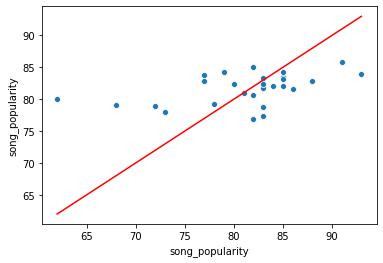

In [116]:
sns.scatterplot(x=y_test_th, y=pred)
sns.lineplot(x=y_test_th, y=y_test_th, color='r')

**Residual analysis:**
* Normal Distribution?
* Independency?
* Homoscedasticity?

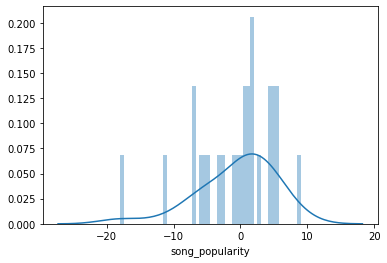

In [117]:
sns.distplot((y_test_th-pred),bins=50);

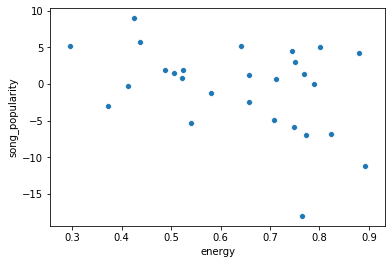

In [118]:
#Plot the residuals against some of our feature X

sns.scatterplot(x=X_test_th['energy'], y=(y_test_th-pred))

#Try other features

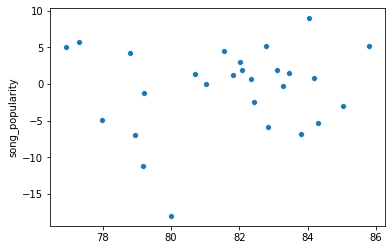

In [119]:
#Homoscedasticity?
sns.scatterplot(x=pred, y=(y_test_th-pred))

* Heteroscedasticity: variance seems to be larger at the beginning and smaller in the end
* Better model for high values of popularity

* Overall, Regression did not perform well
* We manage to get a model slightly better than a dummy predictor using LassoCV
* We have selected different features through various methods but some of them were recurrent:
 * AU
 * FR
 * company_Universal
 * company_Warner
 * energy
 * latin/reggaeton
 * r&b
 * soundtrack
 * group/gender_solo_female

In [120]:
set(list(indexes)).intersection(set(selected_frw), set(selected_bkw))

{'AU',
 'FR',
 'company_Universal',
 'company_Warner',
 'energy',
 'genre_latin/reggaeton',
 'genre_r&b',
 'genre_soundtrack',
 'group/gender_solo_female'}

# Classification

In [121]:
#Different Train and Test split than with regression
#Use Stratify argument to maintain class distribution
#We keep the ability to test different thresholds to exclude outliers

X = df[df['song_popularity']>=0][song_metadata+artist_metadata+audio_features]
y = df[df['song_popularity']>=0][target_features[2]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=10)

In [122]:
#Testing a threshold at 40 to remove outliers
#NB: by doing so, popular songs represent 22% instead of 20% 
X_th = df[df['song_popularity']>=40][song_metadata+artist_metadata+audio_features]
y_th = df[df['song_popularity']>=40][target_features[2]]

X_train_th, X_test_th, y_train_th, y_test_th = train_test_split(X_th, y_th, stratify=y_th, test_size=0.25, random_state=10)

In [123]:
#Scaling 1
scaler = StandardScaler()

scaled_data = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X.columns)

scaled_test_data = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [124]:
#Scaling 2
scaler_th = StandardScaler()

scaled_data_th = pd.DataFrame(data=scaler_th.fit_transform(X_train_th), columns=X_th.columns)

scaled_test_data_th = pd.DataFrame(data=scaler_th.transform(X_test_th), columns=X_th.columns)

In [125]:
#Scaling 3 - Lyrics
idx_tr = X_train.index
idx_te = X_test.index

idx_th_tr = X_train_th.index
idx_th_te = X_test_th.index

#Lyrics_1 (without TFIDF) - no threshold
X_train_lyr_1 = lyrics_1.iloc[idx_tr]
X_test_lyr_1 = lyrics_1.iloc[idx_te]

scal_lyr_1 = StandardScaler(with_mean=False)
scal_lyr_1_data = pd.DataFrame(data=scal_lyr_1.fit_transform(X_train_lyr_1), columns=X_train_lyr_1.columns)
scal_lyr_1_test_data = pd.DataFrame(data=scal_lyr_1.transform(X_test_lyr_1), columns=X_test_lyr_1.columns)

#Lyrics_1 (without TFIDF) - with threshold
X_train_th_lyr_1 = lyrics_1.iloc[idx_th_tr]
X_test_th_lyr_1 = lyrics_1.iloc[idx_th_te]

scal_th_lyr_1 = StandardScaler(with_mean=False)
scal_th_lyr_1_data = pd.DataFrame(data=scal_th_lyr_1.fit_transform(X_train_th_lyr_1), columns=X_train_th_lyr_1.columns)
scal_th_lyr_1_test_data = pd.DataFrame(data=scal_lyr_1.transform(X_test_th_lyr_1), columns=X_test_th_lyr_1.columns)

#Lyrics_2 (with TFIDF) - no threshold
X_train_lyr_2 = lyrics_2.iloc[idx_tr]
X_test_lyr_2 = lyrics_2.iloc[idx_te]

scal_lyr_2 = StandardScaler(with_mean=False)
scal_lyr_2_data = pd.DataFrame(data=scal_lyr_2.fit_transform(X_train_lyr_2), columns=X_train_lyr_2.columns)
scal_lyr_2_test_data = pd.DataFrame(data=scal_lyr_2.transform(X_test_lyr_2), columns=X_test_lyr_2.columns)

#Lyrics_2 (with TFIDF) - with threshold
X_train_th_lyr_2 = lyrics_2.iloc[idx_th_tr]
X_test_th_lyr_2 = lyrics_2.iloc[idx_th_te]

scal_th_lyr_2 = StandardScaler(with_mean=False)
scal_th_lyr_2_data = pd.DataFrame(data=scal_th_lyr_2.fit_transform(X_train_th_lyr_2), columns=X_train_th_lyr_2.columns)
scal_th_lyr_2_test_data = pd.DataFrame(data=scal_lyr_2.transform(X_test_th_lyr_2), columns=X_test_th_lyr_2.columns)

## Logistic Regression
* Standardize data
* Train / Test split
* Result anaysis: F1 score / Precision-Recall / unbalanced classes ==> AUC might not be a good metric 
* With unbalanced classes, we can use weigths for our class 1, parameter 'unbalanced' ? 
* Tunning the Threshold? --> in the context of music, it it  better to increase precision or recall ?
* Use regularization? Bias vs Variance? 
* Sensitive to outliers

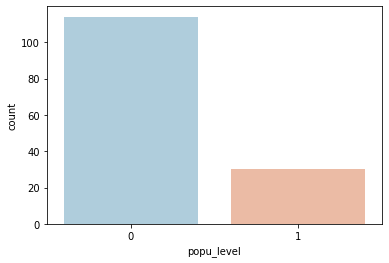

In [126]:
#distribution - approx 20% of Hits
sns.countplot(x='popu_level', data=df, palette='RdBu_r')

In [129]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

### Song Metadata

In [130]:
features = song_metadata

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.22222222]
F1 score - Test set: [0.]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86        28
           1       0.00      0.00      0.00         8

    accuracy                           0.75        36
   macro avg       0.39      0.48      0.43        36
weighted avg       0.60      0.75      0.67        36



* High Bias + Ovefitting ==> Add features

### Artist Metadata

In [131]:
features = artist_metadata

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.38709677]
F1 score - Test set: [0.5]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        28
           1       0.75      0.38      0.50         8

    accuracy                           0.83        36
   macro avg       0.80      0.67      0.70        36
weighted avg       0.82      0.83      0.81        36



* Bias
* Better predictive power than song_metadata

### Audio Features

In [132]:
features = audio_features

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.28571429]
F1 score - Test set: [0.18181818]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        28
           1       0.33      0.12      0.18         8

    accuracy                           0.75        36
   macro avg       0.56      0.53      0.52        36
weighted avg       0.69      0.75      0.70        36



* Better results on Test set

### Combinations

**No threshold:**

In [133]:
features = artist_metadata+song_metadata

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.75]
F1 score - Test set: [0.42857143]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.50      0.38      0.43         8

    accuracy                           0.78        36
   macro avg       0.67      0.63      0.65        36
weighted avg       0.76      0.78      0.77        36



* Overfitting

In [134]:
features = audio_features+song_metadata

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.58823529]
F1 score - Test set: [0.13333333]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        28
           1       0.14      0.12      0.13         8

    accuracy                           0.64        36
   macro avg       0.45      0.46      0.45        36
weighted avg       0.62      0.64      0.63        36



* Overfitting + bias

In [135]:
features = artist_metadata+audio_features

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.61111111]
F1 score - Test set: [0.4]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.43      0.38      0.40         8

    accuracy                           0.75        36
   macro avg       0.63      0.62      0.62        36
weighted avg       0.74      0.75      0.74        36



* Overfitting

In [136]:
features = song_metadata+artist_metadata+audio_features

logmodel = LogisticRegression()
logmodel.fit(scaled_data[features], y_train)

pred = logmodel.predict(scaled_test_data[features])
pred_train = logmodel.predict(scaled_data[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(classification_report(y_test,pred, zero_division=0))

F1 score - Train set: [0.8372093]
F1 score - Test set: [0.26666667]
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.29      0.25      0.27         8

    accuracy                           0.69        36
   macro avg       0.54      0.54      0.54        36
weighted avg       0.68      0.69      0.69        36



* Overfitting ==> regularization

Try to apply regularization for a combination of the 3 feature sets and artist_metadata+song_metadata

**Adding a threshold**

In [137]:
#threshold
features = song_metadata+artist_metadata+audio_features

logmodel = LogisticRegression()
logmodel.fit(scaled_data_th[features], y_train_th)

pred = logmodel.predict(scaled_test_data_th[features])
pred_train = logmodel.predict(scaled_data_th[features])

print(f"F1 score - Train set: {metrics.f1_score(y_train_th, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test_th, pred, average=None, labels=[1])}")
print(classification_report(y_test_th,pred, zero_division=0))

F1 score - Train set: [0.95238095]
F1 score - Test set: [0.15384615]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.20      0.12      0.15         8

    accuracy                           0.68        34
   macro avg       0.48      0.49      0.48        34
weighted avg       0.63      0.68      0.65        34



* Overfitting even more the Train set
* Less powerful on Test set
==> We will not use threshold furthermore for Logistic Regression

### Feature Selection using Select From Model:
* Use the following methods to select different features: Lasso, Random Forest ==> SelectFromModel
* Then with the selected features, apply Logistic Regression with Cross Validation and Regularization on the defined feature sets

In [138]:
#Creating a Solver
f1_class1 = make_scorer(metrics.f1_score, average=None, labels=[1], zero_division=0)

**Lasso Selection:**

In [163]:
#Large C will keep features (complex model) and small C will simplify our hypothesis function
C = [2329, 2329] #from past results - we used np.logspace(-5, 5) 

selector_lasso = SelectFromModel(estimator=LogisticRegressionCV(Cs=C, penalty='l1', cv=StratifiedKFold(n_splits=5,shuffle=True),
                                                                scoring=f1_class1, solver='liblinear'),
                                 threshold=0.03)

selector_lasso.fit(scaled_data, y_train)

#print(selector_lasso.estimator_.coef_)
print(selector_lasso.estimator_.C_)

selected_data = selector_lasso.transform(scaled_data)
selected_test_data = selector_lasso.transform(scaled_test_data)

[2329]


In [166]:
#With Selection of features using LogisticRegressionCV with Ridge to reduce Variance
C = np.logspace(-5, 5)

logmodel_lasso = LogisticRegressionCV(Cs=C, penalty='l2', cv=StratifiedKFold(n_splits=5,shuffle=True), 
                                      scoring=f1_class1, solver='liblinear')
logmodel_lasso.fit(selected_data, y_train)

pred = logmodel_lasso.predict(selected_test_data)
pred_train = logmodel_lasso.predict(selected_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(f"Selected C using CV: {logmodel_lasso.C_}")
print(classification_report(y_test, pred, zero_division=0))

F1 score - Train set: [0.61538462]
F1 score - Test set: [0.60869565]
Selected C using CV: [0.00449843]
              precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.47      0.88      0.61         8

    accuracy                           0.75        36
   macro avg       0.71      0.79      0.71        36
weighted avg       0.84      0.75      0.77        36



* F1-score of 0.61 on Test Set
* Balanced F1 score between Train and Test set
* C parameter: 0.007 - 0.004
* Overall, 54 features were kept during the selection process

In [167]:
column_names_lasso = scaled_data.columns[(selector_lasso.get_support())]

print(f"nb of features selected: {len(column_names_lasso)}")

coeff_ridge = pd.DataFrame(data=logmodel_lasso.coef_.reshape(column_names_lasso.shape), index=column_names_lasso, 
                           columns=['Coeff']).sort_values(by='Coeff')
coeff_ridge

nb of features selected: 54


,Coeff
energy,-0.037146
peak_after,-0.030747
company_Sony,-0.030394
age,-0.022805
CA,-0.021577
danceability,-0.019477
AU,-0.018708
company_Warner,-0.018531
month,-0.017745
speechiness,-0.017275


**Ridge Regularization over the whole dataset:**
We try this because we noticed that only a few features were not selected by the LassoRegularization

In [183]:
C = [0.007, 0.007] # C-value of 0.007 ==> F1-score of 0.61 on Test Set - np.logspace(-5, 5)

logmodel_ridge = LogisticRegressionCV(Cs=C, penalty='l2', cv=StratifiedKFold(n_splits=5,shuffle=True), 
                                      scoring=f1_class1, solver='liblinear')
logmodel_ridge.fit(scaled_data, y_train)

pred = logmodel_ridge.predict(scaled_test_data)
pred_train = logmodel_ridge.predict(scaled_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(f"Selected C using CV: {logmodel_ridge.C_}")
print(classification_report(y_test, pred, zero_division=0))

F1 score - Train set: [0.64]
F1 score - Test set: [0.60869565]
Selected C using CV: [0.007]
              precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.47      0.88      0.61         8

    accuracy                           0.75        36
   macro avg       0.71      0.79      0.71        36
weighted avg       0.84      0.75      0.77        36



* F1-score of 0.61 on Test Set
* Balanced F1 score between Train and Test set
* C parameter: 0.007 ==> small C value, our algorithm simplifies our hypothesis function
* Better to reduce the dimensions of our dataset (Curse of dimensionality)

**Random Forest Selection:**
* Select features
* Train Regularized LogisticRegression with l2 norm

Pay attention to correlated features and features with many categories (Key for instance)

In [184]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
selector_rfc = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100), threshold='median')
                                                       
selector_rfc.fit(X_train, y_train)

selected_data = selector_rfc.transform(scaled_data)
selected_test_data = selector_rfc.transform(scaled_test_data)

selector_rfc.threshold_

0.004350800565497138

In [193]:
C = [0.01, 0.013] #np.logspace(-2, 2) #C-value selected before - [0.01]

logmodel_rfc = LogisticRegressionCV(Cs=C, penalty='l2', cv=StratifiedKFold(n_splits=5,shuffle=True), 
                                    scoring=f1_class1, solver='liblinear')
logmodel_rfc.fit(selected_data, y_train)

pred = logmodel_rfc.predict(selected_test_data)
pred_train = logmodel_rfc.predict(selected_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(f"Selected C using CV: {logmodel_rfc.C_}")
print(classification_report(y_test, pred, zero_division=0))

F1 score - Train set: [0.59090909]
F1 score - Test set: [0.66666667]
Selected C using CV: [0.01]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.60      0.75      0.67         8

    accuracy                           0.83        36
   macro avg       0.76      0.80      0.78        36
weighted avg       0.85      0.83      0.84        36



In [194]:
column_names_rfc = X_train.columns[(selector_rfc.get_support())]

print(f"nb of features selected: {len(column_names_rfc)}")

coeff_ridge = pd.DataFrame(data=logmodel_rfc.coef_.reshape(column_names_rfc.shape), index=column_names_rfc, 
                           columns=['Coeff']).sort_values(by='Coeff')
coeff_ridge

nb of features selected: 33


,Coeff
energy,-0.067588
peak_after,-0.058053
age,-0.039435
danceability,-0.036318
speechiness,-0.036271
month,-0.035055
instrumentalness,-0.033681
album_type_single,-0.026986
group/gender_group_mixed,-0.023839
peak_before,-0.016219


* We have similar performance than with the Lasso selection
* Even if the F1-score is inferior, the model is probably better given the fact that we have less features
* Also, by running this code several times, the results are much more stable than with the Lasso Selection process

### Dummy Classifier

In [195]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

pred_dummy = dummy.predict(X_test)

print(classification_report(y_test, pred_dummy))

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        28
           1       0.21      0.38      0.27         8

    accuracy                           0.56        36
   macro avg       0.49      0.49      0.48        36
weighted avg       0.65      0.56      0.59        36



* Overall, our models performed better than a Dummy Classifier on the same Test Set

In [196]:
intersec = column_names_rfc.intersection(column_names_lasso)
intersec

Index(['duration_ms', 'explicit_lyrics', 'name_length', 'holiday_effect',
       'album_type_single', 'genre_pop', 'genre_rock', 'month',
       'company_Independent, Sony', 'company_Independent, Warner',
       'company_Universal', 'artist_popularity_mean', 'followers_mean',
       'GT_std_value', 'GT_range_value', 'peak_before', 'peak_at',
       'peak_after', 'age', 'group/gender_group_mixed',
       'group/gender_solo_male', 'US', 'key', 'mode', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'valence', 'tempo'],
      dtype='object')

* The results with Logistic Regression are better than with Linear Regression
* The Classification task seems to be more effective
* Features selected by both methods: ``duration_ms``, ``explicit_lyrics``, ``name_length``, ``holiday_effect``, ``album_type_single``, ``genre_hip-hop/rap``, ``genre_pop``, ``genre_rock``, ``month``, ``company_Independent, Sony``, ``company_Universal``, ``artist_popularity_mean``, ``followers_mean``, ``GT_std_value``, ``GT_range_value``, ``peak_before``, ``peak_at``, ``peak_after``, ``age``, ``group/gender_solo_male``, ``GB``, ``IT``, ``US``, ``key``, ``mode``, ``acousticness``, ``danceability``, ``energy``, ``instrumentalness``, ``liveness``, ``loudness``, ``speechiness``, ``valence``, ``tempo``

### The use of Lyrics for classification

In [197]:
#We perform Lasso Regularization to reduce our dimensionality

C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 40, 50, 80, 90, 100] #np.logspace(-5, 2) - force strong selection of words

selector_lasso_lyr = SelectFromModel(estimator=LogisticRegressionCV(Cs=C, penalty='l1', cv=StratifiedKFold(n_splits=5,shuffle=True),
                                                                    scoring=f1_class1, solver='liblinear'),
                                     threshold=0.1)

selector_lasso_lyr.fit(scal_lyr_1_data, y_train)

#print(selector_lasso.estimator_.coef_)
print(selector_lasso_lyr.estimator_.C_)

selected_data_lyr = selector_lasso_lyr.transform(scal_lyr_1_data)
selected_test_data_lyr = selector_lasso_lyr.transform(scal_lyr_1_test_data)

[50]


In [198]:
words_selected = scal_lyr_1_data.columns[(selector_lasso_lyr.get_support())]
print(words_selected)
print(len(words_selected))

Index(['40', 'alcohol', 'bathroom', 'bein', 'blowin', 'bodi', 'class', 'come',
       'complic', 'damag', 'deep', 'dive', 'drop', 'easi', 'fashion',
       'favorit', 'fear', 'fine', 'give', 'grace', 'hate', 'head', 'hear',
       'juic', 'jumpin', 'kinda', 'left', 'lesson', 'love', 'low', 'move',
       'much', 'nobodi', 'one', 'pay', 'poison', 'pool', 'put', 'ride', 'run',
       'sad', 'seat', 'shawti', 'shirt', 'sinc', 'sit', 'sky', 'slip',
       'sometim', 'soul', 'spirit', 'straight', 'stranger', 'street',
       'sublimin', 'suicid', 'summer', 'talk', 'tattoo', 'tell', 'time',
       'today', 'told', 'travel', 'uh', 'weve', 'world'],
      dtype='object')
67


In [199]:
#Combine those words with the features selected by both methods - Use LogisticRegression with L1 

C = np.logspace(-5, 5) #Selected before - 0.00068665

tr = pd.concat([scaled_data[intersec], scal_lyr_1_data[words_selected]], axis=1)
te = pd.concat([scaled_test_data[intersec], scal_lyr_1_test_data[words_selected]], axis=1)

logmodel_lyr = LogisticRegressionCV(Cs=C, penalty='l2', cv=StratifiedKFold(n_splits=4,shuffle=True), 
                                      scoring=f1_class1, solver='liblinear')
logmodel_lyr.fit(tr, y_train)

pred = logmodel_lyr.predict(te)
pred_train = logmodel_lyr.predict(tr)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_train, average=None, labels=[1])}")
print(f"F1 score - Test set: {metrics.f1_score(y_test, pred, average=None, labels=[1])}")
print(f"Selected C using CV: {logmodel_lyr.C_}")

print(classification_report(y_test, pred, zero_division=0))

F1 score - Train set: [0.95238095]
F1 score - Test set: [0.57142857]
Selected C using CV: [0.00068665]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        28
           1       0.67      0.50      0.57         8

    accuracy                           0.83        36
   macro avg       0.77      0.71      0.73        36
weighted avg       0.82      0.83      0.82        36



* Strong Overfitting but not so bad on test set compared to other Logistic Regression models
* Hard to test the model with few examples

## K Nearest Neighbors
* Train / Test split
* Scale Data
* Quick try using all features/features selected during logistic regression
* Hard to use lyrics (sparse data?)

In [206]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [201]:
#Every feature - no threshold
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(scaled_data,y_train)

pred_knn = knn.predict(scaled_test_data)

print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.43      0.38      0.40         8

    accuracy                           0.75        36
   macro avg       0.63      0.62      0.62        36
weighted avg       0.74      0.75      0.74        36



In [202]:
#Every features - threshold
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(scaled_data_th,y_train_th)

pred_knn = knn.predict(scaled_test_data_th)

print(classification_report(y_test_th,pred_knn))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        26
           1       0.67      0.50      0.57         8

    accuracy                           0.82        34
   macro avg       0.76      0.71      0.73        34
weighted avg       0.81      0.82      0.81        34



In [203]:
#Selected features - no threshold

knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(scaled_data[intersec],y_train)

pred_knn = knn.predict(scaled_test_data[intersec])

print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        28
           1       0.50      0.12      0.20         8

    accuracy                           0.78        36
   macro avg       0.65      0.54      0.54        36
weighted avg       0.73      0.78      0.72        36



In [204]:
#Selected features - threshold
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(scaled_data_th[intersec],y_train_th)

pred_knn = knn.predict(scaled_test_data_th[intersec])

print(classification_report(y_test_th,pred_knn))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.50      0.25      0.33         8

    accuracy                           0.76        34
   macro avg       0.65      0.59      0.60        34
weighted avg       0.73      0.76      0.73        34



* Better results with threshold but all features

### GridSearchCV: threshold + every feature

In [207]:
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights':['uniform', 'distance'], 'p':[2,1]}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, scoring = f1_class1, 
                    cv=StratifiedKFold(n_splits=5,shuffle=True))

grid.fit(scaled_data_th, y_train_th)

pred_grid = grid.predict(scaled_test_data_th)

print(classification_report(y_test_th,pred_grid))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.50      0.50      0.50         8

    accuracy                           0.76        34
   macro avg       0.67      0.67      0.67        34
weighted avg       0.76      0.76      0.76        34



In [208]:
grid.best_params_

{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

* Straightforward algorithm
* Should be interesting to test on a large dataset with all our features

## Random Forest
* Robust to Outliers
* How many Trees? 
* Risk of overfitting with one Decision Tree
* Entropy values to determine good features
* Train / Test split
* Try with all features and then only with selected features (during Logistic Regression)

In [209]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [210]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        28
           1       0.50      0.12      0.20         8

    accuracy                           0.78        36
   macro avg       0.65      0.54      0.54        36
weighted avg       0.73      0.78      0.72        36



**Selection of features**

In [212]:
selector_rfc = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100), threshold='median')
                                                       
selector_rfc.fit(X_train, y_train)

selected_data = selector_rfc.transform(X_train)
selected_test_data = selector_rfc.transform(X_test)

selector_rfc.threshold_

0.004386503608578259

In [213]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(selected_data, y_train)
pred_rfc = rfc.predict(selected_test_data)

print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85        28
           1       0.33      0.12      0.18         8

    accuracy                           0.75        36
   macro avg       0.56      0.53      0.52        36
weighted avg       0.69      0.75      0.70        36



### RandomizedSearch CV and GridSearch CV: selected features

In [220]:
#Random Parameter Grid

n_estimators = np.linspace(10, 500, 10, dtype=int)
max_features = ['auto', 'log2', None]
max_depth = list(np.linspace(10, 120, 10, dtype=int))+[None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]
max_samples = [None, 0.9, 0.8, 0.7, 0.6, 0.5]

param_grid_random = {'n_estimators':n_estimators,
                    'max_features':max_features,
                    'max_depth':max_depth,
                    'min_samples_split':min_samples_split,
                    'min_samples_leaf':min_samples_leaf,
                    'bootstrap':bootstrap,
                    'class_weight':class_weight,
                    'max_samples':max_samples}

grid_random = RandomizedSearchCV(RandomForestClassifier(), param_grid_random, n_iter=200,
                                 cv=StratifiedKFold(n_splits=4,shuffle=True), n_jobs=-1,
                                 scoring=f1_class1)
grid_random.fit(selected_data, y_train)

grid_random.best_params_

{'n_estimators': 64,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_samples': 0.6,
 'max_features': None,
 'max_depth': 71,
 'class_weight': None,
 'bootstrap': True}

In [221]:
random_pred = grid_random.predict(selected_test_data)
print(classification_report(y_test, random_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        28
           1       0.25      0.12      0.17         8

    accuracy                           0.72        36
   macro avg       0.52      0.51      0.50        36
weighted avg       0.66      0.72      0.69        36



In [223]:
#Improve the model with GridSearchCV
param_grid = {'n_estimators': list(np.linspace(50, 150, 5, dtype=int)),
              'min_samples_split': [5, 6],
              'min_samples_leaf': [1, 2, 3],
              'max_samples': [None, 0.9],
              'max_features': ['auto'],
              'max_depth': [10, 20],
              'class_weight': [None],
              'bootstrap': [False, True]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, scoring = f1_class1, 
                    cv=StratifiedKFold(n_splits=5,shuffle=True))

grid.fit(selected_data, y_train)

pred_grid = grid.predict(selected_test_data)

print(classification_report(y_test, pred_grid))

              precision    recall  f1-score   support

           0       0.79      0.93      0.85        28
           1       0.33      0.12      0.18         8

    accuracy                           0.75        36
   macro avg       0.56      0.53      0.52        36
weighted avg       0.69      0.75      0.70        36



In [224]:
grid.best_params_

{'bootstrap': False,
 'class_weight': None,
 'max_depth': 10,
 'max_features': 'auto',
 'max_samples': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

### Addition of selected lyrics
* Use of our model with random parameters

In [225]:
tr = np.concatenate((selected_data, np.array(scal_lyr_1_data[words_selected])), axis=1)
te = np.concatenate((selected_test_data, np.array(scal_lyr_1_test_data[words_selected])), axis=1)

rfc_lyr = RandomForestClassifier(bootstrap=True, class_weight=None, max_depth=10, max_features=None, 
                                 max_samples=None, min_samples_leaf=3, min_samples_split=5, n_estimators=60)
rfc_lyr.fit(tr, y_train)

pred_lyr_rfc = rfc_lyr.predict(te)

print(classification_report(y_test, pred_lyr_rfc))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        28
           1       0.25      0.12      0.17         8

    accuracy                           0.72        36
   macro avg       0.52      0.51      0.50        36
weighted avg       0.66      0.72      0.69        36



* It does not improve our model

* Worst model tested in classification
* Accurate model ==> are the results of other algorithms accurate?

## Support Vector Machines
* Small dataset and many features ==> Linear kernel
* But still, we do not have many features if we do not include lyrics ==> Gaussian kernel for complex hypothesis
* n large compare to m ==> Linear kernel
* Feature scaling before Gaussian kernel
* Train / Test split
* Scale data (even for Linear)
* Parameters: C, gamma (small = gaussian fir large variance ie overfitting and large = bias)
* Adjust parameters if it predicts everything to 0

In [226]:
from sklearn.svm import SVC, LinearSVC

In [227]:
#Linear SVC - All features - No threshold
svm_linear = LinearSVC(penalty='l2', loss='squared_hinge',
                       C=1.0, class_weight=None, max_iter=2000)

svm_linear.fit(scaled_data, y_train)

pred_svm_linear = svm_linear.predict(scaled_test_data)
pred_svm_linear_tr = svm_linear.predict(scaled_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_linear_tr, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_linear))

F1 score - Train set: [1.]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.30      0.38      0.33         8

    accuracy                           0.67        36
   macro avg       0.55      0.56      0.56        36
weighted avg       0.69      0.67      0.68        36



In [228]:
#Linear SVC - All features - with threshold
svm_linear = LinearSVC(penalty='l2', loss='squared_hinge',
                       C=1.0, class_weight=None, max_iter=2000)

svm_linear.fit(scaled_data_th, y_train_th)

pred_svm_linear = svm_linear.predict(scaled_test_data_th)
pred_svm_linear_tr = svm_linear.predict(scaled_data_th)

print(f"F1 score - Train set: {metrics.f1_score(y_train_th, pred_svm_linear_tr, average=None, labels=[1])}")
print(classification_report(y_test_th, pred_svm_linear))

F1 score - Train set: [0.97674419]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        26
           1       0.40      0.50      0.44         8

    accuracy                           0.71        34
   macro avg       0.62      0.63      0.62        34
weighted avg       0.73      0.71      0.72        34



In [229]:
#Gaussian RBF kernel SVC - All features - No threshold
svm_gaussian = SVC(C=1.0, kernel='rbf', gamma='auto', class_weight=None,
                   max_iter=2000)

svm_gaussian.fit(scaled_data, y_train)

pred_svm_gaussian = svm_gaussian.predict(scaled_test_data)
pred_svm_gaussian_tr = svm_gaussian.predict(scaled_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_gaussian_tr, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_gaussian, zero_division=0))

F1 score - Train set: [0.37037037]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        28
           1       0.00      0.00      0.00         8

    accuracy                           0.78        36
   macro avg       0.39      0.50      0.44        36
weighted avg       0.60      0.78      0.68        36



In [230]:
#Gaussian RBF kernel SVC - All features - With threshold
svm_gaussian = SVC(C=1.0, kernel='rbf', gamma='auto', class_weight=None,
                   max_iter=2000)

svm_gaussian.fit(scaled_data_th, y_train_th)

pred_svm_gaussian = svm_gaussian.predict(scaled_test_data_th)
pred_svm_gaussian_tr = svm_gaussian.predict(scaled_data_th)

print(f"F1 score - Train set: {metrics.f1_score(y_train_th, pred_svm_gaussian_tr, average=None, labels=[1])}")
print(classification_report(y_test_th, pred_svm_gaussian, zero_division=0))

F1 score - Train set: [0.37037037]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        26
           1       0.00      0.00      0.00         8

    accuracy                           0.76        34
   macro avg       0.38      0.50      0.43        34
weighted avg       0.58      0.76      0.66        34



* Linear Kernel seems to perform better
* Reduced Train set provides better results (but this is relative to Test Set)
* Strong overfitting
* Gaussian Kernel gives poor results but needs to be tuned to analyze the results: test various C and Gamma values 

### Feature selection
* Use Lasso Regularization with SVM algorithm
* Use features selected by RandomForest model
* We do so on the whole Training set (no threshold) because we are already overfitting (f1=1)

In [231]:
selector_svm_lasso = SelectFromModel(estimator=LinearSVC(C=1.0, penalty='l1', loss='squared_hinge', dual=False, 
                                                         class_weight=None, max_iter=2000),                                 
                                     threshold='mean')

selector_svm_lasso.fit(scaled_data, y_train)

selected_data = selector_svm_lasso.transform(scaled_data)
selected_test_data = selector_svm_lasso.transform(scaled_test_data)

In [232]:
#Testing on Linear Kernel
svm_linear = LinearSVC(penalty='l2', loss='squared_hinge',
                       C=1.0, class_weight=None, max_iter=1000)

svm_linear.fit(selected_data, y_train)

pred_svm_linear = svm_linear.predict(selected_test_data)
pred_svm_linear_tr = svm_linear.predict(selected_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_linear_tr, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_linear))

F1 score - Train set: [0.8372093]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        28
           1       0.14      0.12      0.13         8

    accuracy                           0.64        36
   macro avg       0.45      0.46      0.45        36
weighted avg       0.62      0.64      0.63        36



In [233]:
#Testing on Gaussian Kernel
svm_gaussian = SVC(C=1.0, kernel='rbf', gamma='auto', class_weight=None,
                   max_iter=2000)

svm_gaussian.fit(selected_data, y_train)

pred_svm_gaussian = svm_gaussian.predict(selected_test_data)
pred_svm_gaussian_tr = svm_gaussian.predict(selected_data)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_gaussian_tr, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_gaussian, zero_division=0))

F1 score - Train set: [0.48275862]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        28
           1       0.00      0.00      0.00         8

    accuracy                           0.78        36
   macro avg       0.39      0.50      0.44        36
weighted avg       0.60      0.78      0.68        36



In [234]:
#Testing features selected by RandomForest - Linear Kernel
svm_linear = LinearSVC(penalty='l2', loss='squared_hinge',
                       C=1.0, class_weight=None, max_iter=2000)

svm_linear.fit(scaled_data[column_names_rfc], y_train)

pred_svm_linear = svm_linear.predict(scaled_test_data[column_names_rfc])
pred_svm_linear_tr = svm_linear.predict(scaled_data[column_names_rfc])

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_linear_tr, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_linear))

F1 score - Train set: [0.55555556]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.57      0.50      0.53         8

    accuracy                           0.81        36
   macro avg       0.72      0.70      0.71        36
weighted avg       0.80      0.81      0.80        36



* Both feature sets: lasso selection and random forest selection provides interesting results ==> the first leads to overfitting the training set while the second is more balanced

**Features:**
* Random Forest features include all the ones selected through Lasso regularization

In [235]:
column_names_svm_lasso = scaled_data.columns[(selector_svm_lasso.get_support())]
len(column_names_svm_lasso)

24

In [236]:
(set(column_names_rfc) and set(column_names_svm_lasso)) == set(column_names_svm_lasso)

True

### Improving the model with GridSearch CV
* We will tune both models using GridSearchCV and selected features

In [249]:
#Linear Kernel and Gaussian Kernel - column_names_svm_lasso
param_grid = [{'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear'], 
               'class_weight':[None, 'balanced']},
              
              {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
               'kernel': ['rbf'], 'class_weight':[None, 'balanced']}
             ]

grid = GridSearchCV(SVC(), param_grid, refit=True, scoring=f1_class1, cv=StratifiedKFold(n_splits=5, shuffle=True))

grid.fit(selected_data, y_train)

grid.best_params_

{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}

In [250]:
grid.best_score_

0.5297402597402597

In [251]:
pred_grid = grid.predict(selected_test_data)
print(classification_report(y_test, pred_grid))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.32      0.75      0.44         8

    accuracy                           0.58        36
   macro avg       0.60      0.64      0.56        36
weighted avg       0.76      0.58      0.62        36



In [252]:
pd.DataFrame(grid.cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score',
       'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_C,param_class_weight,param_kernel,param_gamma,mean_test_score,std_test_score,rank_test_score
143,1000,balanced,rbf,0.0001,0.529740,0.273800,1
126,100,balanced,rbf,0.001,0.513074,0.262175,2
110,10,balanced,rbf,0.001,0.511702,0.090001,3
127,100,balanced,rbf,0.0001,0.500793,0.081546,4
7,0.1,balanced,linear,NaN,0.493077,0.259065,5
5,0.01,balanced,linear,NaN,0.472308,0.039102,6
10,10,None,linear,NaN,0.470952,0.241773,7
9,1,balanced,linear,NaN,0.459744,0.266642,8
13,100,balanced,linear,NaN,0.447619,0.156521,9
142,1000,balanced,rbf,0.001,0.445455,0.261661,10


In [257]:
#Linear Kernel and Gaussian Kernel - column_names_rfc
param_grid = [{'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear'], 
               'class_weight':[None, 'balanced']},
              
              {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
               'kernel': ['rbf'], 'class_weight':[None, 'balanced']}
             ]

grid = GridSearchCV(SVC(), param_grid, refit=True, scoring=f1_class1, cv=StratifiedKFold(n_splits=3, shuffle=True))

grid.fit(scaled_data[column_names_rfc], y_train)

grid.best_params_

{'C': 100, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}

In [258]:
grid.best_score_

0.42481203007518803

In [259]:
pred_grid = grid.predict(scaled_test_data[column_names_rfc])
print(classification_report(y_test,pred_grid))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67        28
           1       0.32      0.75      0.44         8

    accuracy                           0.58        36
   macro avg       0.60      0.64      0.56        36
weighted avg       0.76      0.58      0.62        36



In [260]:
pd.DataFrame(grid.cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score',
       'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_C,param_class_weight,param_kernel,param_gamma,mean_test_score,std_test_score,rank_test_score
127,100,balanced,rbf,0.0001,0.424812,0.193245,1
110,10,balanced,rbf,0.001,0.399471,0.167776,2
7,0.1,balanced,linear,NaN,0.388314,0.072656,3
143,1000,balanced,rbf,0.0001,0.381965,0.081623,4
5,0.01,balanced,linear,NaN,0.369464,0.153590,5
10,10,None,linear,NaN,0.369444,0.027499,6
126,100,balanced,rbf,0.001,0.365139,0.052596,7
93,1,balanced,rbf,0.01,0.352769,0.133139,8
14,1000,None,linear,NaN,0.348148,0.073330,9
13,100,balanced,linear,NaN,0.338889,0.061363,10


* Best Tuning with features selected through Lasso Regularization

**Try to improve our results**

In [268]:
param_grid = [{'C':[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'kernel':['linear'], 
               'class_weight':['balanced']},
              
              {'C':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'gamma':[0.001, 0.0005, 0.0001, 0.00005, 0.00001], 
               'kernel': ['rbf'], 'class_weight':['balanced']}
             ]

grid = GridSearchCV(SVC(), param_grid, refit=True, scoring=f1_class1, cv=StratifiedKFold(n_splits=5, shuffle=True))

grid.fit(selected_data, y_train)

print(grid.best_params_)

print(grid.best_score_)

{'C': 700, 'class_weight': 'balanced', 'gamma': 1e-05, 'kernel': 'rbf'}
0.49377955377955374


In [269]:
pred_grid = grid.predict(selected_test_data)
print(classification_report(y_test,pred_grid))
print(confusion_matrix(y_test,pred_grid))

              precision    recall  f1-score   support

           0       0.94      0.54      0.68        28
           1       0.35      0.88      0.50         8

    accuracy                           0.61        36
   macro avg       0.64      0.71      0.59        36
weighted avg       0.81      0.61      0.64        36

[[15 13]
 [ 1  7]]


In [270]:
pd.DataFrame(grid.cv_results_)[['param_C', 'param_class_weight', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score',
       'rank_test_score']].sort_values(by='rank_test_score').head(10)

,param_C,param_class_weight,param_kernel,param_gamma,mean_test_score,std_test_score,rank_test_score
45,700,balanced,rbf,1e-05,0.493780,0.043738,1
0,0.01,balanced,linear,NaN,0.456996,0.044554,2
35,500,balanced,rbf,1e-05,0.456996,0.044554,2
40,600,balanced,rbf,1e-05,0.456996,0.044554,2
14,100,balanced,rbf,5e-05,0.450403,0.045815,5
22,300,balanced,rbf,0.0005,0.445152,0.145532,6
4,0.4,balanced,linear,NaN,0.445152,0.145532,6
3,0.3,balanced,linear,NaN,0.445152,0.145532,6
27,400,balanced,rbf,0.0005,0.437879,0.148485,9
50,800,balanced,rbf,1e-05,0.429133,0.109309,10


In [271]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.001279,0.000060,0.001429,0.000037,700,balanced,rbf,1e-05,"{'C': 700, 'class_weight': 'balanced', 'gamma'...",0.461538,0.533333,0.500000,0.545455,0.428571,0.493780,0.043738,1
0,0.001553,0.000279,0.001525,0.000080,0.01,balanced,linear,NaN,"{'C': 0.01, 'class_weight': 'balanced', 'kerne...",0.428571,0.533333,0.461538,0.461538,0.400000,0.456996,0.044554,2
35,0.001510,0.000406,0.001769,0.000345,500,balanced,rbf,1e-05,"{'C': 500, 'class_weight': 'balanced', 'gamma'...",0.428571,0.533333,0.461538,0.461538,0.400000,0.456996,0.044554,2
40,0.001227,0.000009,0.001408,0.000005,600,balanced,rbf,1e-05,"{'C': 600, 'class_weight': 'balanced', 'gamma'...",0.428571,0.533333,0.461538,0.461538,0.400000,0.456996,0.044554,2
14,0.001270,0.000045,0.001591,0.000223,100,balanced,rbf,5e-05,"{'C': 100, 'class_weight': 'balanced', 'gamma'...",0.428571,0.533333,0.428571,0.461538,0.400000,0.450403,0.045815,5
22,0.001362,0.000108,0.001395,0.000012,300,balanced,rbf,0.0005,"{'C': 300, 'class_weight': 'balanced', 'gamma'...",0.363636,0.666667,0.545455,0.250000,0.400000,0.445152,0.145532,6
4,0.002146,0.000487,0.001694,0.000236,0.4,balanced,linear,NaN,"{'C': 0.4, 'class_weight': 'balanced', 'kernel...",0.363636,0.666667,0.545455,0.250000,0.400000,0.445152,0.145532,6
3,0.001741,0.000281,0.001582,0.000061,0.3,balanced,linear,NaN,"{'C': 0.3, 'class_weight': 'balanced', 'kernel...",0.363636,0.666667,0.545455,0.250000,0.400000,0.445152,0.145532,6
27,0.001455,0.000119,0.001483,0.000113,400,balanced,rbf,0.0005,"{'C': 400, 'class_weight': 'balanced', 'gamma'...",0.363636,0.666667,0.545455,0.250000,0.363636,0.437879,0.148485,9
50,0.001225,0.000016,0.001405,0.000011,800,balanced,rbf,1e-05,"{'C': 800, 'class_weight': 'balanced', 'gamma'...",0.461538,0.533333,0.500000,0.222222,0.428571,0.429133,0.109309,10


* Results are average, we thought that SVM could produce better results than Logistic Regression
* By running several time the code, Gaussian and Linear Kernels perform equally
* Would be interesting to try this algorithm on a larger dataset
* Stability in terms of results

### Addition of Lyrics

In [272]:
tr = np.concatenate((selected_data, np.array(scal_lyr_1_data[words_selected])), axis=1)
te = np.concatenate((selected_test_data, np.array(scal_lyr_1_test_data[words_selected])), axis=1)

param_grid = [{'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':['linear'], 
               'class_weight':[None, 'balanced']},
              
              {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
               'kernel': ['rbf'], 'class_weight':[None, 'balanced']}
             ]

grid = GridSearchCV(SVC(), param_grid, refit=True, scoring=f1_class1, cv=StratifiedKFold(n_splits=5, shuffle=True))

grid.fit(tr, y_train)

print(grid.best_params_)

pred_svm_lyr = grid.predict(te)
pred_svm_lyr_train = grid.predict(tr)

print(f"F1 score - Train set: {metrics.f1_score(y_train, pred_svm_lyr_train, average=None, labels=[1])}")
print(classification_report(y_test, pred_svm_lyr))

{'C': 10, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
F1 score - Train set: [1.]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.38      0.38      0.38         8

    accuracy                           0.72        36
   macro avg       0.60      0.60      0.60        36
weighted avg       0.72      0.72      0.72        36



In [273]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
142,0.002016,0.000237,0.001677,0.000271,1000,balanced,rbf,0.001,"{'C': 1000, 'class_weight': 'balanced', 'gamma...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
110,0.001602,0.000028,0.001460,0.000018,10,balanced,rbf,0.001,"{'C': 10, 'class_weight': 'balanced', 'gamma':...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
118,0.001662,0.000197,0.001706,0.000316,100,None,rbf,0.001,"{'C': 100, 'class_weight': None, 'gamma': 0.00...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
126,0.001604,0.000036,0.001456,0.000008,100,balanced,rbf,0.001,"{'C': 100, 'class_weight': 'balanced', 'gamma'...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
102,0.001791,0.000287,0.001942,0.000336,10,None,rbf,0.001,"{'C': 10, 'class_weight': None, 'gamma': 0.001...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
134,0.001701,0.000157,0.001869,0.000331,1000,None,rbf,0.001,"{'C': 1000, 'class_weight': None, 'gamma': 0.0...",0.857143,1.000000,0.750000,0.857143,0.857143,0.864286,0.079539,1
93,0.001805,0.000184,0.001769,0.000359,1,balanced,rbf,0.01,"{'C': 1, 'class_weight': 'balanced', 'gamma': ...",1.000000,0.833333,0.888889,0.400000,0.857143,0.795873,0.206006,7
143,0.002080,0.000318,0.001963,0.000226,1000,balanced,rbf,0.0001,"{'C': 1000, 'class_weight': 'balanced', 'gamma...",0.857143,0.888889,0.571429,0.857143,0.666667,0.768254,0.126028,8
119,0.001641,0.000188,0.001715,0.000381,100,None,rbf,0.0001,"{'C': 100, 'class_weight': None, 'gamma': 0.00...",0.857143,0.888889,0.571429,0.857143,0.666667,0.768254,0.126028,8
135,0.001673,0.000197,0.001613,0.000160,1000,None,rbf,0.0001,"{'C': 1000, 'class_weight': None, 'gamma': 0.0...",0.857143,0.888889,0.571429,0.857143,0.666667,0.768254,0.126028,8


## Multilayer Neural Network
* We try to apply Neural Network to our classification task which seems to be more promissing compared to the regression task
* We use features selected by RandomForest / LogisticRegressionCV with Lasso / p-value in the analysis notebook (with spearman and pearsonr)


* Train/Test split
* Dense layers: every neuron is connected to every neuron in the next layer
* Choose an Optimizer: RMSprop, Adam
* Choose a loss function: "binary_crossentropy"
* Choose a metric for classification: "f1_score" / our scorer
* Batch = choose a batch as large as we can afford
* Epoch = Too many epoch ==> overfitting

* Optimization: nb of layers? nb of units? optimization algorithm? 

NB: Neural Networks perform better on balanced Dataset ==> We implement a Cost-Sensitive Neural Network

In [274]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K

In [275]:
#Creating a validation set
scaled_data_tf, scaled_test_data_tf, y_train_tf, y_test_tf = train_test_split(scaled_data, y_train, stratify=y_train, 
                                                                              test_size=0.2, random_state=10)

In [276]:
def get_f1(y_true, y_pred): #taken from old keras source code
    
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    pred_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = TP / (pred_positives + K.epsilon())
    recall = TP / (positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

In [279]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

rmsprop = RMSprop(learning_rate=0.0009) #default = 0.001
adam = Adam(learning_rate=0.0009) #default = 0.001

l2_reg = tf.keras.regularizers.l2(l=3.5) #Best Class 3.5

#weight_for_0 = (1 / (y_train_tf==0).sum()) * (len(y_train_tf)) / 2.0
#weight_for_1 = (1 / (y_train_tf==1).sum()) * (len(y_train_tf)) / 2.0
#class_weight = {0:weight_for_0, 1:weight_for_1}

class_weight = {0:1, 1:3.45} 

In [280]:
print(weight_for_0)
print(weight_for_1)

0.6323529411764706
2.388888888888889


In [281]:
scaled_data_tf[column_names_rfc].shape

(86, 33)

In [307]:
#choisr nb de layer et de units
model = Sequential()

model.add(Dense(units=40, input_shape=(33,), activation='relu', #Other Best results with 50-55
                kernel_initializer='he_uniform', kernel_regularizer=l2_reg, use_bias=True))
model.add(Dropout(0.35)) #Other Best results with 0.5

model.add(Dense(units=1, activation='sigmoid')) 

model.compile(optimizer=adam , loss='binary_crossentropy', metrics=[get_f1])

In [308]:
#early stop pas nécessaire
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

model.fit(x=scaled_data_tf[column_names_rfc].values, 
          y=y_train_tf.values, 
          #validation_split=0.2,
          validation_data=(scaled_test_data_tf[column_names_rfc].values, y_test_tf.values),
          batch_size=200, #To have 100% chance of having 0 and 1 in one batch
          epochs=1600,
          verbose=1,
          class_weight=class_weight,
          callbacks=[early_stop])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 86 samples, validate on 22 samples
Epoch 1/1600
86/86 [==============================] - 1s 8ms/sample - loss: 285.0278 - get_f1: 0.2667 - val_loss: 279.3920 - val_get_f1: 0.1176
Epoch 2/1600
86/86 [==============================] - 0s 140us/sample - loss: 279.4821 - get_f1: 0.2857 - val_loss: 272.2200 - val_get_f1: 0.1176
Epoch 3/1600
86/86 [==============================] - 0s 126us/sample - loss: 272.3738 - get_f1: 0.2154 - val_loss: 264.0334 - val_get_f1: 0.1176
Epoch 4/1600
86/86 [==============================] - 0s 120us/sample - loss: 264.1983 - get_f1: 0.2121 - val_loss: 255.2392 - val_get_f1: 0.1250
Epoch 5/1600
86/86 [==============================] - 0s 117us/sample - loss: 255.4967 - get_f1: 0.1379 - val_loss: 246.1088 - val_get_f1: 0.1250
Epoch 6/1600
86/86 [==============================] - 0s 112us/sample - loss: 246.2926 - get_f1: 0.2500 - val_loss: 236.8279 - val_get_f1: 0.1333
Epoch 7/1600
86/86 [============

Epoch 56/1600
86/86 [==============================] - 0s 143us/sample - loss: 30.5018 - get_f1: 0.5200 - val_loss: 29.5407 - val_get_f1: 0.0000e+00
Epoch 57/1600
86/86 [==============================] - 0s 127us/sample - loss: 29.3946 - get_f1: 0.5000 - val_loss: 28.4980 - val_get_f1: 0.0000e+00
Epoch 58/1600
86/86 [==============================] - 0s 128us/sample - loss: 28.3711 - get_f1: 0.3913 - val_loss: 27.4983 - val_get_f1: 0.0000e+00
Epoch 59/1600
86/86 [==============================] - 0s 130us/sample - loss: 27.3602 - get_f1: 0.4783 - val_loss: 26.5393 - val_get_f1: 0.0000e+00
Epoch 60/1600
86/86 [==============================] - 0s 110us/sample - loss: 26.4119 - get_f1: 0.4651 - val_loss: 25.6192 - val_get_f1: 0.0000e+00
Epoch 61/1600
86/86 [==============================] - 0s 146us/sample - loss: 25.5048 - get_f1: 0.4091 - val_loss: 24.7361 - val_get_f1: 0.0000e+00
Epoch 62/1600
86/86 [==============================] - 0s 125us/sample - loss: 24.6523 - get_f1: 0.3333 - 

Epoch 112/1600
86/86 [==============================] - 0s 148us/sample - loss: 5.3324 - get_f1: 0.5714 - val_loss: 5.2591 - val_get_f1: 0.0000e+00
Epoch 113/1600
86/86 [==============================] - 0s 115us/sample - loss: 5.1919 - get_f1: 0.5641 - val_loss: 5.1251 - val_get_f1: 0.0000e+00
Epoch 114/1600
86/86 [==============================] - 0s 104us/sample - loss: 5.0753 - get_f1: 0.5000 - val_loss: 4.9954 - val_get_f1: 0.0000e+00
Epoch 115/1600
86/86 [==============================] - 0s 130us/sample - loss: 4.9310 - get_f1: 0.5946 - val_loss: 4.8700 - val_get_f1: 0.0000e+00
Epoch 116/1600
86/86 [==============================] - 0s 157us/sample - loss: 4.8052 - get_f1: 0.5000 - val_loss: 4.7489 - val_get_f1: 0.0000e+00
Epoch 117/1600
86/86 [==============================] - 0s 134us/sample - loss: 4.6828 - get_f1: 0.5946 - val_loss: 4.6317 - val_get_f1: 0.0000e+00
Epoch 118/1600
86/86 [==============================] - 0s 105us/sample - loss: 4.5378 - get_f1: 0.7000 - val_lo

Epoch 168/1600
86/86 [==============================] - 0s 134us/sample - loss: 1.7593 - get_f1: 0.5161 - val_loss: 1.7443 - val_get_f1: 0.0000e+00
Epoch 169/1600
86/86 [==============================] - 0s 132us/sample - loss: 1.7230 - get_f1: 0.4865 - val_loss: 1.7219 - val_get_f1: 0.0000e+00
Epoch 170/1600
86/86 [==============================] - 0s 133us/sample - loss: 1.7025 - get_f1: 0.5294 - val_loss: 1.7001 - val_get_f1: 0.0000e+00
Epoch 171/1600
86/86 [==============================] - 0s 145us/sample - loss: 1.7277 - get_f1: 0.3243 - val_loss: 1.6790 - val_get_f1: 0.0000e+00
Epoch 172/1600
86/86 [==============================] - 0s 118us/sample - loss: 1.6753 - get_f1: 0.3889 - val_loss: 1.6585 - val_get_f1: 0.0000e+00
Epoch 173/1600
86/86 [==============================] - 0s 138us/sample - loss: 1.6487 - get_f1: 0.5161 - val_loss: 1.6388 - val_get_f1: 0.0000e+00
Epoch 174/1600
86/86 [==============================] - 0s 150us/sample - loss: 1.6149 - get_f1: 0.6111 - val_lo

Epoch 224/1600
86/86 [==============================] - 0s 129us/sample - loss: 1.1349 - get_f1: 0.5161 - val_loss: 1.1293 - val_get_f1: 0.0000e+00
Epoch 225/1600
86/86 [==============================] - 0s 122us/sample - loss: 1.1424 - get_f1: 0.3889 - val_loss: 1.1252 - val_get_f1: 0.0000e+00
Epoch 226/1600
86/86 [==============================] - 0s 132us/sample - loss: 1.1349 - get_f1: 0.4211 - val_loss: 1.1213 - val_get_f1: 0.0000e+00
Epoch 227/1600
86/86 [==============================] - 0s 119us/sample - loss: 1.1510 - get_f1: 0.5000 - val_loss: 1.1175 - val_get_f1: 0.0000e+00
Epoch 228/1600
86/86 [==============================] - 0s 135us/sample - loss: 1.1158 - get_f1: 0.4615 - val_loss: 1.1136 - val_get_f1: 0.0000e+00
Epoch 229/1600
86/86 [==============================] - 0s 126us/sample - loss: 1.1232 - get_f1: 0.6286 - val_loss: 1.1099 - val_get_f1: 0.2857
Epoch 230/1600
86/86 [==============================] - 0s 130us/sample - loss: 1.1548 - get_f1: 0.3636 - val_loss: 

Epoch 281/1600
86/86 [==============================] - 0s 113us/sample - loss: 1.0270 - get_f1: 0.4211 - val_loss: 1.0112 - val_get_f1: 0.2500
Epoch 282/1600
86/86 [==============================] - 0s 148us/sample - loss: 1.0285 - get_f1: 0.5263 - val_loss: 1.0108 - val_get_f1: 0.2500
Epoch 283/1600
86/86 [==============================] - 0s 127us/sample - loss: 1.0188 - get_f1: 0.5294 - val_loss: 1.0102 - val_get_f1: 0.2500
Epoch 284/1600
86/86 [==============================] - 0s 127us/sample - loss: 1.0282 - get_f1: 0.5263 - val_loss: 1.0094 - val_get_f1: 0.2500
Epoch 285/1600
86/86 [==============================] - 0s 121us/sample - loss: 1.0039 - get_f1: 0.6667 - val_loss: 1.0086 - val_get_f1: 0.2500
Epoch 286/1600
86/86 [==============================] - 0s 136us/sample - loss: 1.0305 - get_f1: 0.3333 - val_loss: 1.0079 - val_get_f1: 0.2500
Epoch 287/1600
86/86 [==============================] - 0s 126us/sample - loss: 1.0307 - get_f1: 0.4103 - val_loss: 1.0072 - val_get_f1:

Epoch 338/1600
86/86 [==============================] - 0s 135us/sample - loss: 1.0007 - get_f1: 0.3889 - val_loss: 0.9853 - val_get_f1: 0.2857
Epoch 339/1600
86/86 [==============================] - 0s 120us/sample - loss: 1.0054 - get_f1: 0.4878 - val_loss: 0.9852 - val_get_f1: 0.2857
Epoch 340/1600
86/86 [==============================] - 0s 120us/sample - loss: 1.0041 - get_f1: 0.6471 - val_loss: 0.9853 - val_get_f1: 0.2857
Epoch 341/1600
86/86 [==============================] - 0s 125us/sample - loss: 1.0050 - get_f1: 0.4865 - val_loss: 0.9853 - val_get_f1: 0.2857
Epoch 342/1600
86/86 [==============================] - 0s 119us/sample - loss: 0.9948 - get_f1: 0.4211 - val_loss: 0.9855 - val_get_f1: 0.2857
Epoch 343/1600
86/86 [==============================] - 0s 114us/sample - loss: 0.9911 - get_f1: 0.5143 - val_loss: 0.9858 - val_get_f1: 0.2857
Epoch 344/1600
86/86 [==============================] - 0s 126us/sample - loss: 0.9960 - get_f1: 0.5500 - val_loss: 0.9859 - val_get_f1:

Epoch 395/1600
86/86 [==============================] - 0s 126us/sample - loss: 1.0007 - get_f1: 0.5789 - val_loss: 0.9837 - val_get_f1: 0.4000
Epoch 396/1600
86/86 [==============================] - 0s 114us/sample - loss: 0.9876 - get_f1: 0.5263 - val_loss: 0.9838 - val_get_f1: 0.4000
Epoch 397/1600
86/86 [==============================] - 0s 123us/sample - loss: 0.9991 - get_f1: 0.5714 - val_loss: 0.9838 - val_get_f1: 0.2222
Epoch 398/1600
86/86 [==============================] - 0s 113us/sample - loss: 0.9830 - get_f1: 0.5854 - val_loss: 0.9838 - val_get_f1: 0.2222
Epoch 399/1600
86/86 [==============================] - 0s 107us/sample - loss: 0.9884 - get_f1: 0.5641 - val_loss: 0.9839 - val_get_f1: 0.2222
Epoch 400/1600
86/86 [==============================] - 0s 125us/sample - loss: 1.0103 - get_f1: 0.5641 - val_loss: 0.9839 - val_get_f1: 0.2222
Epoch 401/1600
86/86 [==============================] - 0s 125us/sample - loss: 0.9850 - get_f1: 0.5714 - val_loss: 0.9839 - val_get_f1:

Epoch 452/1600
86/86 [==============================] - 0s 113us/sample - loss: 0.9865 - get_f1: 0.5263 - val_loss: 0.9816 - val_get_f1: 0.4000
Epoch 453/1600
86/86 [==============================] - 0s 120us/sample - loss: 0.9857 - get_f1: 0.5263 - val_loss: 0.9810 - val_get_f1: 0.4000
Epoch 454/1600
86/86 [==============================] - 0s 105us/sample - loss: 0.9811 - get_f1: 0.5128 - val_loss: 0.9804 - val_get_f1: 0.4000
Epoch 455/1600
86/86 [==============================] - 0s 131us/sample - loss: 0.9984 - get_f1: 0.5000 - val_loss: 0.9795 - val_get_f1: 0.4000
Epoch 456/1600
86/86 [==============================] - 0s 107us/sample - loss: 0.9753 - get_f1: 0.5500 - val_loss: 0.9788 - val_get_f1: 0.4000
Epoch 457/1600
86/86 [==============================] - 0s 135us/sample - loss: 0.9924 - get_f1: 0.6000 - val_loss: 0.9782 - val_get_f1: 0.4000
Epoch 458/1600
86/86 [==============================] - 0s 143us/sample - loss: 0.9855 - get_f1: 0.6842 - val_loss: 0.9777 - val_get_f1:

Epoch 509/1600
86/86 [==============================] - 0s 151us/sample - loss: 0.9953 - get_f1: 0.6000 - val_loss: 0.9791 - val_get_f1: 0.4444
Epoch 510/1600
86/86 [==============================] - 0s 122us/sample - loss: 0.9789 - get_f1: 0.6500 - val_loss: 0.9790 - val_get_f1: 0.4444
Epoch 511/1600
86/86 [==============================] - 0s 125us/sample - loss: 0.9898 - get_f1: 0.5238 - val_loss: 0.9789 - val_get_f1: 0.4444
Epoch 512/1600
86/86 [==============================] - 0s 130us/sample - loss: 0.9771 - get_f1: 0.5405 - val_loss: 0.9788 - val_get_f1: 0.4444
Epoch 513/1600
86/86 [==============================] - 0s 121us/sample - loss: 0.9723 - get_f1: 0.5778 - val_loss: 0.9786 - val_get_f1: 0.4444
Epoch 514/1600
86/86 [==============================] - 0s 121us/sample - loss: 0.9887 - get_f1: 0.5405 - val_loss: 0.9784 - val_get_f1: 0.4444
Epoch 515/1600
86/86 [==============================] - 0s 120us/sample - loss: 0.9622 - get_f1: 0.6000 - val_loss: 0.9779 - val_get_f1:

Epoch 566/1600
86/86 [==============================] - 0s 111us/sample - loss: 0.9917 - get_f1: 0.5641 - val_loss: 0.9777 - val_get_f1: 0.4000
Epoch 567/1600
86/86 [==============================] - 0s 130us/sample - loss: 0.9576 - get_f1: 0.5854 - val_loss: 0.9777 - val_get_f1: 0.4000
Epoch 568/1600
86/86 [==============================] - 0s 111us/sample - loss: 0.9599 - get_f1: 0.6154 - val_loss: 0.9776 - val_get_f1: 0.4000
Epoch 569/1600
86/86 [==============================] - 0s 110us/sample - loss: 0.9493 - get_f1: 0.6190 - val_loss: 0.9776 - val_get_f1: 0.4000
Epoch 570/1600
86/86 [==============================] - 0s 130us/sample - loss: 0.9608 - get_f1: 0.6341 - val_loss: 0.9775 - val_get_f1: 0.4444
Epoch 571/1600
86/86 [==============================] - 0s 102us/sample - loss: 0.9526 - get_f1: 0.5366 - val_loss: 0.9772 - val_get_f1: 0.4444
Epoch 572/1600
86/86 [==============================] - 0s 127us/sample - loss: 0.9851 - get_f1: 0.5366 - val_loss: 0.9770 - val_get_f1:

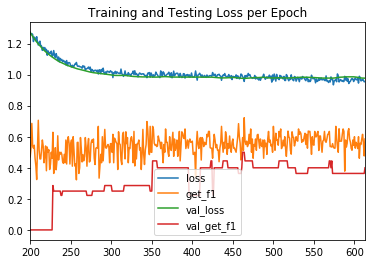

In [309]:
#Evaluation
loss = pd.DataFrame(model.history.history) #Jtrain and Jtest
loss.iloc[200:].plot()

plt.title("Training and Testing Loss per Epoch");

In [310]:
loss[['get_f1', 'val_get_f1']].max()

get_f1        0.722222
val_get_f1    0.500000
dtype: float64

In [311]:
#Validation Set
pred_ann_val = model.predict_classes(scaled_test_data_tf[column_names_rfc].values)
print(confusion_matrix(y_test_tf,pred_ann_val))
print(classification_report(y_test_tf,pred_ann_val))

[[16  2]
 [ 2  2]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.50      0.50      0.50         4

    accuracy                           0.82        22
   macro avg       0.69      0.69      0.69        22
weighted avg       0.82      0.82      0.82        22



In [312]:
pred_ann = model.predict_classes(scaled_test_data[column_names_rfc].values)

In [313]:
print(confusion_matrix(y_test,pred_ann))
print(classification_report(y_test,pred_ann))

[[23  5]
 [ 1  7]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.58      0.88      0.70         8

    accuracy                           0.83        36
   macro avg       0.77      0.85      0.79        36
weighted avg       0.88      0.83      0.84        36

